# Week 2 - Corpus Linguistics

This week, we take text corpora that we have developed, spidered, scraped, and encoded, and we find and count words and simple phrases and properties of those counts (e.g., word frequency distributions). Initially, we model how to search corpora for keywords or phrases. Next, we examine the distributions of terms and phrases across a corpus, and the corelation between different words and phrase counts. In order to do this effectively, we coarsely disambiguate words based of part-of-speech (POS) tagging, and normalize them through stemming and lemmatization. Next we distinguish *important* words and phrase within the corpus, and image them with Wordls! Then we calculate word frequenceis, conditional frequences (the frequency of word *shock* conditional on the presence of word *awe*), and statistically significant collocations of lengths 2 through $n$. Finally, we calculate and visualize Differences (Divergences and Distances) between the word frequency distributions from two corpora. 

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
import lucem_illud #pip install git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import requests #for http requests
import nltk #the Natural Language Toolkit
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns #makes our plots look nicer
import sklearn.manifold #For a manifold plot
from nltk.corpus import stopwords #For stopwords
import json #For API responses
import urllib.parse #For joining urls

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook
%matplotlib inline

# Retrieving exemplary corpora

To get started we will need some examples. Let's start by downloading one of the corpuses from `nltk`, a Natural Language Toolkit developed by computational linguists at the University of Pennsylvania. Let's take a look at how that works.

First we can get a list of works available from the Gutenburg corpus, with the [corpus module](http://www.nltk.org/api/nltk.corpus.html). To do this we will need to tell nltk where the data are, and download them if need be.

In [2]:
#You should have them already downloaded in the data directory
try:
    #adding path for both local and server, only one of these will actually be used at a time
    nltk.data.path.append('/project2/macs60000/shared_data/nltk')
    nltk.data.path.append('../data')
    #Check that everything is in place
    nltk.corpus.gutenberg.fileids()
except LookupError:
    print("You have to download all the documents")
    print("Downloading to ../data this should only take a couple minutes")
    nltk.download('all', download_dir = '../data')
    nltk.data.path.append('../data')
#If you haven't downloaded the copura then you will have to run `nltk.download()`
print(nltk.corpus.gutenberg.fileids())
print(len(nltk.corpus.gutenberg.fileids()))

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']
18


We can also look at the individual works

In [3]:
nltk.corpus.gutenberg.raw('shakespeare-macbeth.txt')[2000:4000]

"es,\nBut the Norweyan Lord, surueying vantage,\nWith furbusht Armes, and new supplyes of men,\nBegan a fresh assault\n\n   King. Dismay'd not this our Captaines, Macbeth and\nBanquoh?\n  Cap. Yes, as Sparrowes, Eagles;\nOr the Hare, the Lyon:\nIf I say sooth, I must report they were\nAs Cannons ouer-charg'd with double Cracks,\nSo they doubly redoubled stroakes vpon the Foe:\nExcept they meant to bathe in reeking Wounds,\nOr memorize another Golgotha,\nI cannot tell: but I am faint,\nMy Gashes cry for helpe\n\n   King. So well thy words become thee, as thy wounds,\nThey smack of Honor both: Goe get him Surgeons.\nEnter Rosse and Angus.\n\nWho comes here?\n  Mal. The worthy Thane of Rosse\n\n   Lenox. What a haste lookes through his eyes?\nSo should he looke, that seemes to speake things strange\n\n   Rosse. God saue the King\n\n   King. Whence cam'st thou, worthy Thane?\n  Rosse. From Fiffe, great King,\nWhere the Norweyan Banners flowt the Skie,\nAnd fanne our people cold.\nNorway hi

All the listed works have been nicely marked up and classified for us so we can do much better than just looking at raw text.

In [4]:
print(nltk.corpus.gutenberg.words('shakespeare-macbeth.txt'))
print(nltk.corpus.gutenberg.sents('shakespeare-macbeth.txt'))

['[', 'The', 'Tragedie', 'of', 'Macbeth', 'by', ...]
[['[', 'The', 'Tragedie', 'of', 'Macbeth', 'by', 'William', 'Shakespeare', '1603', ']'], ['Actus', 'Primus', '.'], ...]


# Counting words

If we want to do some analysis we can start by simply counting the number of times each word occurs within the corpus.

In [5]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pandas.DataFrame(countsForFrame)

countedWords = wordCounter(nltk.corpus.gutenberg.words('shakespeare-macbeth.txt'))
countedWords[:10]

count          word
0      9           off
1      3         thick
2      1     visitings
3      1     murderers
4      4         watch
5      1        theefe
6      1  compunctious
7      2        repose
8      1         knees
9      3          tree

Notice how `wordCounter()` is not a very complicated function. That is because the hard parts have already been done by `nltk`. If we were using unprocessed text we would have to tokenize and determine what to do with the non-word characters.

nltk also offers a built-in way for getting a frequency distribution from a list of words:

In [6]:
words = [word.lower() for word in nltk.corpus.gutenberg.words('shakespeare-macbeth.txt')]
freq = nltk.FreqDist(words)
print (freq['macbeth'])

62


Lets sort and plot our counts to investigate the shape of our word frequency distribution.

First we need to sort the words by count.

In [7]:
#Doing this in place (changing the original DataFrame) as we don't need the unsorted DataFrame
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

count    word
3263   1962       ,
3449   1235       .
2707    650     the
124     637       '
657     546     and
1740    477       :
2705    384      to
151     348       i
1439    338      of
1814    241       ?
397     241       a
1057    238    that
1913    224       d
636     206     you
547     203      my
435     201      in
315     188      is
1107    165     not
488     161      it
2618    153    with
3332    146     his
1271    137      be
983     137    macb
1515    131       s
1592    126    your
223     123     our
3242    122    haue
364     120     but
1977    118    what
496     113      me
...     ...     ...
2641     49      by
1305     49    good
2607     49   rosse
1764     49     was
1041     48    lady
2813     48       t
527      48    them
1500     46    time
1933     45      if
131      43    like
1857     43     her
1195     42     did
881      42  should
1580     42      st
1883     42     let
1609     41     say
3411     40    when
352      39    were
955      39  banquo
1691     39    make
1049     39   where
2109     38    lord
2467     38       o
2600     38     doe
2258     37      or
492      37     tis
3382     36    must
1464     36       1
2743     35    know
964      35    done

[100 rows x 2 columns]

Punctuation and very common words (articles 'a' and 'the'; prepositions 'of' and 'to') make up the most common values, but this isn't very interesting and can actually get in the way of our analysis. We may remove these 'function words' by removing according to a stopword list, setting some frequency threshold, or using a weighting scheme (like tf.idf) to decrease their influence (all modeled later in this tutorial).

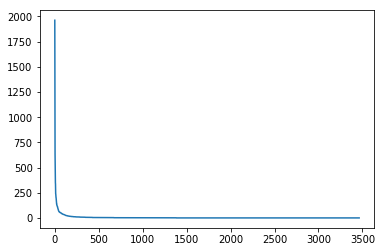

In [8]:
#Creating a figure and axis lets us do things like change the scaling or add a title
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
plt.show()

This shows that likelihood of a word occurring is inversely proportional to its rank. This effect is called [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. Zipf's law is most easily observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.

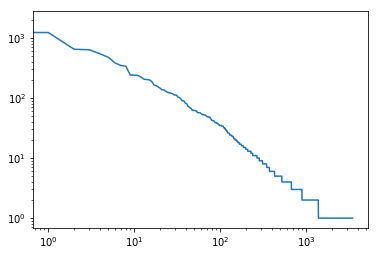

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

(The same relationship occurs in many other rankings, such as population ranks of cities, corporation sizes, income rankings, etc.) 

The distribution was imagined by Zipf to be driven by a principle of 'least effort' where speakers did not work any harder than necessary to communicate a given idea, but the basis for this relationship is still not well understood and conforms at least as well to a process of [preferential attachment](https://en.wikipedia.org/wiki/Preferential_attachment) whereby people disproportionately attend to popular words.

There are many other properties of words we can examine. First lets look surrounding words with the concordance. To do this we need to load the text into a `ConcordanceIndex`

In [10]:
macbethIndex = nltk.text.ConcordanceIndex(nltk.corpus.gutenberg.words('shakespeare-macbeth.txt'))

Then we can retrieve all the words that cooccur with a word in a given word window. Let's first look at `'macbeth'`.

In [11]:
macbethIndex.print_concordance('macbeth')

No matches


Weird?! `'macbeth'` doesn't occur anywhere in the the text. What happened?

`ConcordanceIndex` is case sensitive, lets try looking for `'Macbeth'`

In [12]:
macbethIndex.print_concordance('Macbeth')

Displaying 25 of 61 matches:
                                  Macbeth by William Shakespeare 1603 ] Act
 the Heath 3 . There to meet with Macbeth 1 . I come , Gray - Malkin All . 
but all ' s too weake : For braue Macbeth ( well hee deserues that Name ) D
smay ' d not this our Captaines , Macbeth and Banquoh ? Cap . Yes , as Spar
, And with his former Title greet Macbeth Rosse . Ile see it done King . Wh
 King . What he hath lost , Noble Macbeth hath wonne . Exeunt . Scena Terti
ithin . 3 . A Drumme , a Drumme : Macbeth doth come All . The weyward Siste
, the Charme ' s wound vp . Enter Macbeth and Banquo . Macb . So foule and 
an : what are you ? 1 . All haile Macbeth , haile to thee Thane of Glamis 2
hee Thane of Glamis 2 . All haile Macbeth , haile to thee Thane of Cawdor 3
hee Thane of Cawdor 3 . All haile Macbeth , that shalt be King hereafter Ba
. Hayle 3 . Hayle 1 . Lesser than Macbeth , and greater 2 . Not so happy , 
hough thou be none : So all haile Macbeth , and Banquo 1 . 

That's better. What about something a lot less frequent?

In [13]:
print(countedWords[countedWords['word'] == 'donalbaine'])
macbethIndex.print_concordance('Donalbaine')

      count        word
2017      7  donalbaine
Displaying 7 of 7 matches:
m within . Enter King Malcome , Donalbaine , Lenox , with attendants , mee
Enter King , Lenox , Malcolme , Donalbaine , and Attendants . King . Is ex
rches . Enter King , Malcolme , Donalbaine , Banquo , Lenox , Macduff , Ro
 ' th ' second Chamber ? Lady . Donalbaine Mac . This is a sorry sight Lad
er , and Treason , Banquo , and Donalbaine : Malcolme awake , Shake off th
to brag of . Enter Malcolme and Donalbaine . Donal . What is amisse ? Macb
were subborned , Malcolme , and Donalbaine the Kings two Sonnes Are stolne


# Getting and working with raw text

First, we will retrieve a collection of press releases from a *GitHub API* that archived them, based on a number of analyses by Justin Grimmer, a political scientist whose work we will read next week, and who will be joining the University of Chicago next July!

GitHub API requests are made to `'https://api.github.com/'` and responses are in JSON, similar to Tumblr's API.

We will get the information on [github.com/lintool/GrimmerSenatePressReleases](https://github.com/lintool/GrimmerSenatePressReleases) as it contains a nice set documents.

In [14]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases')
senateReleasesData = json.loads(r.text)
print(senateReleasesData.keys())
print(senateReleasesData['description'])

dict_keys(['comments_url', 'license', 'fork', 'mirror_url', 'archived', 'subscribers_count', 'watchers_count', 'deployments_url', 'url', 'description', 'stargazers_url', 'pushed_at', 'git_url', 'git_refs_url', 'compare_url', 'owner', 'subscription_url', 'watchers', 'html_url', 'events_url', 'git_commits_url', 'contents_url', 'issue_events_url', 'stargazers_count', 'branches_url', 'commits_url', 'labels_url', 'forks', 'updated_at', 'forks_url', 'has_pages', 'archive_url', 'created_at', 'collaborators_url', 'trees_url', 'downloads_url', 'homepage', 'svn_url', 'open_issues_count', 'tags_url', 'teams_url', 'keys_url', 'languages_url', 'blobs_url', 'has_issues', 'private', 'clone_url', 'language', 'network_count', 'issues_url', 'has_downloads', 'ssh_url', 'size', 'statuses_url', 'name', 'full_name', 'subscribers_url', 'git_tags_url', 'has_projects', 'issue_comment_url', 'hooks_url', 'contributors_url', 'forks_count', 'pulls_url', 'default_branch', 'id', 'notifications_url', 'milestones_url'

What we are interested in here is the `'contents_url'`

In [15]:
print(senateReleasesData['contents_url'])

https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/{+path}


We can use this to get any or all of the files from the repo.

In [16]:
r = requests.get('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse')
whitehouseLinks = json.loads(r.text)
whitehouseLinks[0]

{'_links': {'git': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
  'html': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
  'self': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse/10Apr2007Whitehouse123.txt?ref=master'},
 'download_url': 'https://raw.githubusercontent.com/lintool/GrimmerSenatePressReleases/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'git_url': 'https://api.github.com/repos/lintool/GrimmerSenatePressReleases/git/blobs/f524289ee563dca58690c8d36c23dce5dbd9962a',
 'html_url': 'https://github.com/lintool/GrimmerSenatePressReleases/blob/master/raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'name': '10Apr2007Whitehouse123.txt',
 'path': 'raw/Whitehouse/10Apr2007Whitehouse123.txt',
 'sha': 'f524289ee563dca58690c8d36c23dce5dbd9962a',
 'size': 2206,
 'type': 'file',
 'url': 'https://api.github.com/r

Now we have a list of information about Whitehouse press releases. Let's look at one of them.

In [17]:
r = requests.get(whitehouseLinks[0]['download_url'])
whitehouseRelease = r.text
print(whitehouseRelease[:1000])
len(whitehouseRelease)

SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY IN PUSH FOR STEM CELL RESEARCH
  Sharing the story of Lila Barber, a 12 year old girl from Westerly, Sen. Sheldon Whitehouse (D-R.I.) on Tuesday, April 10, 2007, illustrated the hope stem cell research can offer in a speech on the Senate floor in favor of legislation to expand federal funding for stem cell research.  
   Whitehouse met Lila two weeks ago. She was diagnosed two years ago with osteosarcoma, a cancerous bone condition, and last year underwent cadaver bone transplant surgery. The procedure saved her leg and is helping her remain cancer-free, but the transplanted tissue will not grow with her and likely will break down over time. Stem cell research, Whitehouse explained, could vastly improve the care of patients like Lila by allowing surgeons to enhance transplants with a patient's own stem cells, which could replace the lost bone and cartilage, or grow entirely new replacement bones and joints. 
   "Stem cell research gives hope

2206

Now we have a string of correctly encoded text, similar to those we constructed from last week's assignment. For analysis of its words, next we need to tokenize it, or to split it into a sequence of tokens or word instances.

In [18]:
whTokens = nltk.word_tokenize(whitehouseRelease)
whTokens[10:30]

['STEM',
 'CELL',
 'RESEARCH',
 'Sharing',
 'the',
 'story',
 'of',
 'Lila',
 'Barber',
 ',',
 'a',
 '12',
 'year',
 'old',
 'girl',
 'from',
 'Westerly',
 ',',
 'Sen.',
 'Sheldon']

`whTokens` is a list of 'words' constructed from nltk's `word_tokenize` method built on the [Penn Treebank tokenizer](http://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.treebank). While it's better than `.split(' ')`, a general python string method that splits on whitespace, it is not perfect. There are many different ways to tokenize a string. `word_tokenize` is unfortunately unaware of sentences and is essentially a complicated regular expression (regex) run across the string.

If we want to find sentences we can use something like `nltk.sent_tokenize()`, which implements the [Punkt Sentence tokenizer](http://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.punkt.PunktSentenceTokenizer), a machine learning based algorithm that works well for many European languages.

We could also use the [Stanford tokenizer](http://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.stanford) or construct our own regex with [`RegexpTokenizer()`](http://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.regexp). Picking the correct tokenizer is important as the tokens form the base of our analysis.

For our purposes in this example, the Penn Treebank tokenizer is fine.

To use the list of tokens in `nltk`, and take advantage of functions like `concordance`, shown above, we can convert it into a `Text`.

In [19]:
whText = nltk.Text(whTokens)

whitehouseIndex = nltk.text.ConcordanceIndex(whText) 
whitehouseIndex.print_concordance('Whitehouse')

Displaying 5 of 5 matches:
rl from Westerly , Sen. Sheldon Whitehouse ( D-R.I. ) on Tuesday , April 1
unding for stem cell research . Whitehouse met Lila two weeks ago . She wa
ver time . Stem cell research , Whitehouse explained , could vastly improv
ch might help or even cure , '' Whitehouse said . Whitehouse also praised 
ven cure , '' Whitehouse said . Whitehouse also praised the efforts of Rho


*Note* that the `Text` class is for doing rapid, exploratory analysis. It provides an easy interface to many of the operations we want to do, but it does not allow us much control over the particular operations it glosses. When you are doing a more complete analysis, you should be using the module specifically designed for that task instead of the shortcut method `Text` provides, e.g. use  [`collocations` Module](http://www.nltk.org/api/nltk.html#module-nltk.collocations) instead of `.collocations()`.

Now that we have gotten this loaded, let's glance at few features we will delve into more deeply later.

For example, we can find words that statistically tend to occur together and typically have a composite, idiomatic meaning irreducible to the semantics of its component words. We will do this later with more control over exactly how these are identified.

In [20]:
whText.collocations()

Rhode Island; stem cells; cell research; Cell Enhancement; Enhancement
Act; President Bush; Stem Cell; stem cell; Stem cell


Or we can pick a word (or words) and find what words tend to occur around it.

In [21]:
whText.common_contexts(['stem'])

embryonic_cells for_cell ``_cell on_cells ._cell of_cell own_cells
hope_cell the_cell


We can also just count the number of times the word occurs.

In [22]:
whText.count('cell')

5


We can also plot each time a set of words occurs.

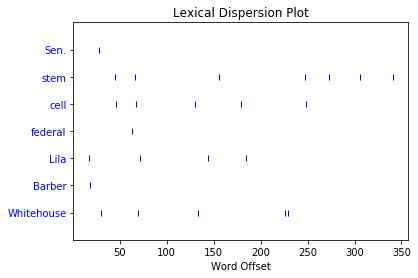

In [23]:
sns.reset_orig() #Seaborn messes with this plot, disabling it
whText.dispersion_plot(['Sen.','stem', 'cell', 'federal' ,'Lila', 'Barber', 'Whitehouse'])
sns.set() #Re-enabling seaborn

If we want to do an analysis of all the Whitehouse press releases we will first need to obtain them. By looking at the API we can see the the URL we want is [https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse](https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse), so we can create a function to scrape the individual files.

If you want to know more about downloading from APIs, refer back to the 1st notebook.

In [24]:
def getGithubFiles(target, maxFiles = 100):
    #We are setting a max so our examples don't take too long to run
    #For converting to a DataFrame
    releasesDict = {
        'name' : [], #The name of the file
        'text' : [], #The text of the file, watch out for binary files
        'path' : [], #The path in the git repo to the file
        'html_url' : [], #The url to see the file on Github
        'download_url' : [], #The url to download the file
    }

    #Get the directory information from Github
    r = requests.get(target)
    filesLst = json.loads(r.text)

    for fileDict in filesLst[:maxFiles]:
        #These are provided by the directory
        releasesDict['name'].append(fileDict['name'])
        releasesDict['path'].append(fileDict['path'])
        releasesDict['html_url'].append(fileDict['html_url'])
        releasesDict['download_url'].append(fileDict['download_url'])

        #We need to download the text though
        text = requests.get(fileDict['download_url']).text
        releasesDict['text'].append(text)

    return pandas.DataFrame(releasesDict)

whReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Whitehouse', maxFiles = 10)
whReleases[:5]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   
3  https://raw.githubusercontent.com/lintool/Grim...   
4  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   

                         name                                       path  \
0  10Apr2007Whitehouse123.txt  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   raw/Whitehouse/10Jan2008Whitehouse35.txt   

                                                text  
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...  
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...  
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...  
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...  
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...

If you are having trouble downloading the data uncomment this next cell

In [25]:
#whReleases = pandas.read_csv('../data/whReleases.csv')

Now we have all the texts in a DataFrame we can look at a few things.

First let's tokenize the texts with the same tokenizer as we used before. We will just save the tokens as a list for now; no need to convert to `Text`s.

In [26]:
whReleases['tokenized_text'] = whReleases['text'].apply(lambda x: nltk.word_tokenize(x))

Now lets see how long each of the press releases is:

In [27]:
whReleases['word_counts'] = whReleases['tokenized_text'].apply(lambda x: len(x))
whReleases['word_counts']

0    397
1    344
2    553
3    216
4    257
5    380
6    270
7    521
8    484
9    482
Name: word_counts, dtype: int64

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that input and interrogate a corpus relating to your anticipated final project. Turn your text into an nltk `Text` object, and explore all of the features examined above, and others that relate to better understanding your corpus in relation to your research question. </span>

I collected plot summaries of comedies directed by Woody Allen and thrillers directed by Alfred Hitchcock to do the following analysis.

In [28]:
# Read WoodyAllen.txt
WoodyAllen = open('WoodyAllen.txt','r')
WoodyAllen = WoodyAllen.read()
print(WoodyAllen)

Virgil Starkwell's (Woody Allen) story is told in documentary style, using both stock footage and interviews with people who knew him. He begins a life of crime at a young age. As a child, Virgil is a frequent target of bullies, who snatch his glasses and stomp on them on the floor. As an adult, Virgil is inept and unlucky, and both police and judges ridicule him by stomping on Virgil's glasses.

Virgil falls in love with a young lady, Louise (Janet Margolin), a laundry worker, and they live together. They even have a baby.

Virgil is arrested for trying to rob a bank after handing to a teller a threatening note with the word "gun" misspelled. He is sent to prison, but attempts an escape using a bar of soap carved to resemble a gun. Unfortunately for him, it was raining outside and his gun dissolves. He does escape, but by accident. Joining a mass breakout plan, Virgil is the only inmate not warned that the scheme had been called off.

Outside but unemployed, Virgil finds no way to sup

In [29]:
# Tokenize WoodyAllen text
waTokens = nltk.word_tokenize(WoodyAllen)
print(waTokens)

['Virgil', 'Starkwell', "'s", '(', 'Woody', 'Allen', ')', 'story', 'is', 'told', 'in', 'documentary', 'style', ',', 'using', 'both', 'stock', 'footage', 'and', 'interviews', 'with', 'people', 'who', 'knew', 'him', '.', 'He', 'begins', 'a', 'life', 'of', 'crime', 'at', 'a', 'young', 'age', '.', 'As', 'a', 'child', ',', 'Virgil', 'is', 'a', 'frequent', 'target', 'of', 'bullies', ',', 'who', 'snatch', 'his', 'glasses', 'and', 'stomp', 'on', 'them', 'on', 'the', 'floor', '.', 'As', 'an', 'adult', ',', 'Virgil', 'is', 'inept', 'and', 'unlucky', ',', 'and', 'both', 'police', 'and', 'judges', 'ridicule', 'him', 'by', 'stomping', 'on', 'Virgil', "'s", 'glasses', '.', 'Virgil', 'falls', 'in', 'love', 'with', 'a', 'young', 'lady', ',', 'Louise', '(', 'Janet', 'Margolin', ')', ',', 'a', 'laundry', 'worker', ',', 'and', 'they', 'live', 'together', '.', 'They', 'even', 'have', 'a', 'baby', '.', 'Virgil', 'is', 'arrested', 'for', 'trying', 'to', 'rob', 'a', 'bank', 'after', 'handing', 'to', 'a', 'te

In [30]:
# Turn WoodyAllen text into an nltk Text object
waText = nltk.Text(waTokens)

In [31]:
# Count the number of times each word occurs within WoodyAllen corpus
wacountedWords = wordCounter(waTokens)
print(wacountedWords)

      count         word
0        15          off
1        32        tells
2         2     director
3         1    forlornly
4         2         whim
5        32        harry
6         1        watch
7         6        based
8         1       dreams
9         2       cosell
10        2     shouting
11        1      coupled
12        2      couples
13        1        nanny
14        3        poses
15        1          aka
16        1  rationalism
17        1         wish
18        1   commentary
19        1         clue
20        1    occurring
21        2     birthday
22        1     directly
23        1          cab
24        1       edited
25        6      escapes
26        1      judaism
27        1    lucrative
28        2     divorced
29        2     pedantic
...     ...          ...
3781      1    sarsgaard
3782      1      engages
3783      8         kiss
3784      3     audition
3785      2   performing
3786      1    ominously
3787      1       kavner
3788      1       milton


In [32]:
# Another way to count the number of times each word occurs within WoodyAllen corpus
wawords = [word.lower() for word in waTokens]
wafreq = nltk.FreqDist(wawords)
print (wafreq['love'])

47


      count           word
0      1051              ,
1       931              .
2       704            the
3       629             to
4       628            and
5       549              a
6       333             is
7       313            her
8       296             he
9       278             in
10      276             of
11      270            his
12      264           with
13      241           that
14      209            she
15      208             's
16      196              (
17      196              )
18      151            him
19      137            for
20      125           they
21      108             at
22      105             on
23       99            who
24       96            has
25       95             as
26       90            but
27       90             an
28       84             by
29       72             it
...     ...            ...
3781      1           fled
3782      1    flexibility
3783      1        reclaim
3784      1        charade
3785      1         hooked
3

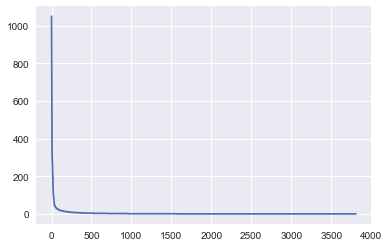

In [33]:
# Sort and plot our counts to investigate the shape of our word frequency distribution
wacountedWords.sort_values('count', ascending=False, inplace=True)
wacountedWords = wacountedWords.reset_index(drop=True)
print(wacountedWords)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(wacountedWords)), wacountedWords['count'])
plt.show()

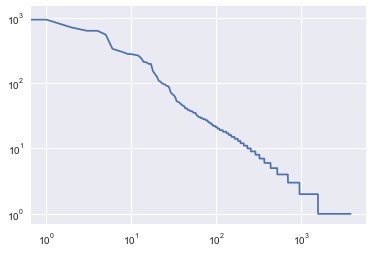

In [34]:
# Plot word frequency on a log-log graph to observe Zipf's law
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(wacountedWords)), wacountedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [35]:
# Explore surrounding words with the concordance
waIndex = nltk.text.ConcordanceIndex(waText)
print(wacountedWords[wacountedWords['word'] == 'love'], '\n')
waIndex.print_concordance('love')

    count  word
39     47  love 

Displaying 25 of 47 matches:
irgil 's glasses . Virgil falls in love with a young lady , Louise ( Janet
s Project . Miles and Luna fall in love , but Miles is captured and brainw
ells him that she believes in free love . Miles and Luna infiltrate the Ar
der . Miles and Luna confess their love for one another , but she claims t
eelings for her are more than just love . When she moves in with him , thi
 on the street about the nature of love , questioning his formative years 
s voice returns with a summation : love is essential , especially if it is
 `` acceptance , forgiveness , and love . '' At first Danny turns Tina awa
 within the film . The two fall in love . But the character 's defection f
 movie ) . This sets up an unusual love triangle involving Tom , Gil , and
usband . But Gil 's professions of love for Cecilia were false—he wooed he
ly , which this time blossoms into love . Holly 's story is the film 's th
cking the subject , Cliff falls in lo

In [36]:
# Find words that statistically tend to occur together and typically have a composite,
# idiomatic meaning irreducible to the semantics of its component words
waText.collocations()

Betty Ann; New York; Juan Antonio; Woody Allen; York City; Tarot Card;
Aries Project; Dr. Yang; María Elena; trigger word; aunt Vanessa;
Diane Keaton; Card Killer; Mia Farrow; hotel room; film ends; Los
Angeles; Mother Teresa; Wallace Shawn; heart attack


In [37]:
# Find what words tend to occur around a certain word (or words)
waText.common_contexts(['love'])

of_for potent_potion true_( true_and make_. in_will of_, in_, in_.
make_in and_. unusual_triangle with_, just_. their_for to_and her_him
a_letter in_before or_.


In [38]:
# Another way to count the number of times the word occurs
waText.count('love')

47

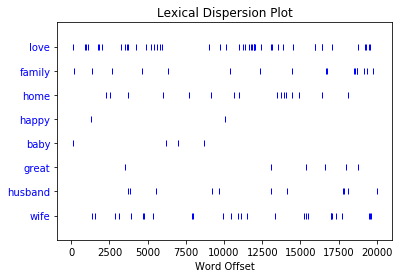

In [39]:
# Plot each time a set of words occurs
sns.reset_orig() #Seaborn messes with this plot, disabling it
waText.dispersion_plot(['love','family', 'home', 'happy' ,'baby', 'great', 'husband', 'wife'])
sns.set() #Re-enabling seaborn

      count           word
0      1749            the
1      1719              ,
2      1480              .
3      1025             to
4       862            and
5       735              a
6       498             is
7       468             he
8       438            her
9       427             of
10      407             in
11      370            his
12      344           that
13      340             's
14      290            she
15      264              (
16      264              )
17      217           with
18      208            him
19      180            for
20      177             at
21      175             as
22      172           they
23      168             by
24      168            but
25      154             on
26      149            has
27      132             ``
28      132             ''
29      129            who
...     ...            ...
5050      1       adjacent
5051      1         levers
5052      1  extravagantly
5053      1         frenzy
5054      1           doll
5

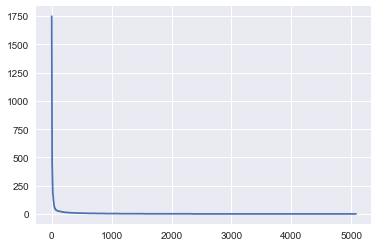

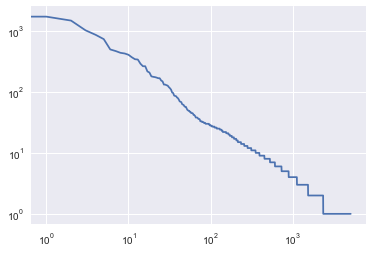

     count  word
218     15  love 

Displaying 15 of 15 matches:
 , it is revealed that Minta is in love with him . Bassett rejects him too
ows of marriage . Kate is still in love with Philip , and can hardly bear 
 gone , he still has their baby to love . Kate persuades Philip to hide he
 former fiancé Jerry proclaims his love for Mary and offers to marry her u
y finally return home , with their love for each other strengthened and se
( in fact , she and Tisdall are in love ) , her father chooses to resign h
 Laurence Olivier ) . They fall in love , and within two weeks they are ma
eves that Maxim is still deeply in love with his first wife . She also dis
ed . Now assured of her husband 's love for her and not his first wife , t
elieves Haverstock does not really love her but only used her to pursue he
e , but she is starting to fall in love with Detective Smith . Smith and E
logizes to Robie and confesses her love . Robie needs to continue his sear
led when she says , `` Mother will 

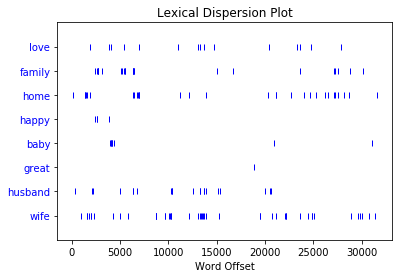

In [40]:
# I repeated the above steps for AlfredHitchcock.txt
AlfredHitchcock = open('AlfredHitchcock.txt','r')
AlfredHitchcock = AlfredHitchcock.read()
ahTokens = nltk.word_tokenize(AlfredHitchcock)
ahText = nltk.Text(ahTokens)

ahcountedWords = wordCounter(ahTokens)
ahcountedWords.sort_values('count', ascending=False, inplace=True)
ahcountedWords = ahcountedWords.reset_index(drop=True)
print(ahcountedWords, '\n')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(ahcountedWords)), ahcountedWords['count'])
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(ahcountedWords)), ahcountedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

ahIndex = nltk.text.ConcordanceIndex(ahText)
print(ahcountedWords[ahcountedWords['word'] == 'love'], '\n')
ahIndex.print_concordance('love')
print('\n')

print(ahText.count('love'))
print('\n')
ahText.common_contexts(['love'])
print('\n')

ahText.collocations()

# Plot each time a set of words occurs
sns.reset_orig() #Seaborn messes with this plot, disabling it
ahText.dispersion_plot(['love','family', 'home', 'happy' ,'baby', 'great', 'husband', 'wife'])
sns.set() #Re-enabling seaborn

# Filtering and normalizing text

As we want to start comparing the different releases we may choose to do a bit of filtering and normalizing that will allow us to focus on what we most care about. We can first make all of the words lower case, then drop the non-word tokens. Next, we can remove some 'stop words', stem the remaining words to remove suffixes, prefixes and (in some languages) infixes, or lemmatize tokens by intelligently grouping inflected or variant forms of the same word (e.g., with a stemmer and a dictionary). 

To begin this process, we will first define a function to work over the tokenized lists, then another to add normalized tokens to a new column.

Nltk has a built-in list of stopwords. They are already imported in the import section. Let's first take a look at what they are.

In [41]:
print(', '.join(stopwords.words('english')))

i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, must

We can remove these stopwords from the analysis by fiat, but we could also take a more principled approach by looking at the frequency distribution of words and selecting a specific cut-off associated with the preservation of 'meaningful words' identified upon inspection. Alternatively, we could automatically set a cut-off by rule, such as removal of all words more frequent then the most frequent verb, or the most frequent noun (not pronoun), or some term of central interest. 

Lets generate our own stop list now.

In [42]:
countsDict = {}
for word in whReleases['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:20]

[('the', 179),
 (',', 173),
 ('.', 136),
 ('to', 112),
 ('of', 112),
 ('and', 108),
 ('in', 64),
 ('a', 61),
 ("'s", 50),
 ('that', 41),
 ('our', 39),
 ('for', 35),
 ('is', 33),
 ('on', 33),
 ('Whitehouse', 31),
 ('``', 30),
 ('Iraq', 28),
 ('Bush', 27),
 ('President', 25),
 ('(', 24)]

We can look at this and pick the cutoff, usually it is at the first noun. So we will cut all words before `'Whitehouse'`.

In [43]:
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'Whitehouse':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq
wordnet = nltk.stem.WordNetLemmatizer()
wordnet.lemmatize('are')

'are'

Now we can create our function to normalize the tokens

In [44]:
stop_words_nltk = stopwords.words('english')
#stop_words = ["the","it","she","he", "a"] #Uncomment this line if you want to use your own list of stopwords.

#The stemmers and lemmers need to be initialized before bing run
porter = nltk.stem.porter.PorterStemmer()
snowball = nltk.stem.snowball.SnowballStemmer('english')
wordnet = nltk.stem.WordNetLemmatizer()

def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)
        
    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)
    
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = porter))

whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))

whReleases

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   
3  https://raw.githubusercontent.com/lintool/Grim...   
4  https://raw.githubusercontent.com/lintool/Grim...   
5  https://raw.githubusercontent.com/lintool/Grim...   
6  https://raw.githubusercontent.com/lintool/Grim...   
7  https://raw.githubusercontent.com/lintool/Grim...   
8  https://raw.githubusercontent.com/lintool/Grim...   
9  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url  \
0  https://github.com/lintool/GrimmerSenatePressR...   
1  https://github.com/lintool/GrimmerSenatePressR...   
2  https://github.com/lintool/GrimmerSenatePressR...   
3  https://github.com/lintool/GrimmerSenatePressR...   
4  https://github.com/lintool/GrimmerSenatePressR...   
5  https://github.com/lintool/GrimmerSenatePressR...   
6  https://github.com/lintool/GrimmerSenatePressR...   
7  https://github.com/lintool/GrimmerSenatePressR...   
8  https://github.com/lintool/GrimmerSenatePressR...   
9  https://github.com/lintool/GrimmerSenatePressR...   

                         name                                       path  \
0  10Apr2007Whitehouse123.txt  raw/Whitehouse/10Apr2007Whitehouse123.txt   
1    10Apr2008Whitehouse2.txt    raw/Whitehouse/10Apr2008Whitehouse2.txt   
2    10Apr2008Whitehouse3.txt    raw/Whitehouse/10Apr2008Whitehouse3.txt   
3   10Aug2007Whitehouse78.txt   raw/Whitehouse/10Aug2007Whitehouse78.txt   
4   10Jan2008Whitehouse35.txt   raw/Whitehouse/10Jan2008Whitehouse35.txt   
5    10Mar2008Whitehouse8.txt    raw/Whitehouse/10Mar2008Whitehouse8.txt   
6   10Sep2007Whitehouse72.txt   raw/Whitehouse/10Sep2007Whitehouse72.txt   
7  11Apr2007Whitehouse122.txt  raw/Whitehouse/11Apr2007Whitehouse122.txt   
8  11Jan2007Whitehouse161.txt  raw/Whitehouse/11Jan2007Whitehouse161.txt   
9    11Mar2008Whitehouse7.txt    raw/Whitehouse/11Mar2008Whitehouse7.txt   

                                                text  \
0  SEN. WHITEHOUSE SHARES WESTERLY GIRL'S STORY I...   
1  SEN. WHITEHOUSE SAYS PRESIDENT BUSH MUST BEGIN...   
2  EPA MUST REVIEW LEGAL PROCESS TO ROOT OUT POLI...   
3  R.I. SENATORS PRAISE SEN. DENIAL OF LNG FACILI...   
4  SEN. WHITEHOUSE COMMENTS ON ONE-YEAR ANNIVERSA...   
5  SENS. REED, WHITEHOUSE WELCOME RHODE ISLAND ST...   
6  REP. WHITEHOUSE ISSUES STATEMENT ON GEN. PETRA...   
7  SEN. WHITEHOUSE URGES BUSH FOR NEW DIRECTION I...   
8  SENS. REED, WHITEHOUSE URGE PORTUGAL TO RECONS...   
9  WHITEHOUSE UNVEILS 'BUSH DEBT': $7.7 TRILLION ...   

                                      tokenized_text  word_counts  \
0  [SEN., WHITEHOUSE, SHARES, WESTERLY, GIRL, 'S,...          397   
1  [SEN., WHITEHOUSE, SAYS, PRESIDENT, BUSH, MUST...          344   
2  [EPA, MUST, REVIEW, LEGAL, PROCESS, TO, ROOT, ...          553   
3  [R.I, ., SENATORS, PRAISE, SEN, ., DENIAL, OF,...          216   
4  [SEN., WHITEHOUSE, COMMENTS, ON, ONE-YEAR, ANN...          257   
5  [SENS, ., REED, ,, WHITEHOUSE, WELCOME, RHODE,...          380   
6  [REP., WHITEHOUSE, ISSUES, STATEMENT, ON, GEN....          270   
7  [SEN., WHITEHOUSE, URGES, BUSH, FOR, NEW, DIRE...          521   
8  [SENS, ., REED, ,, WHITEHOUSE, URGE, PORTUGAL,...          484   
9  [WHITEHOUSE, UNVEILS, 'BUSH, DEBT, ', :, $, 7....          482   

                                   normalized_tokens  normalized_tokens_count  
0  [whitehous, share, westerli, girl, stori, push...                      231  
1  [whitehous, say, presid, bush, must, begin, br...                      171  
2  [epa, must, review, legal, process, root, poli...                      305  
3  [senat, prais, sen, denial, lng, facil, permit...                      115  
4  [whitehous, comment, anniversari, presid, bush...                      132  
5  [sen, reed, whitehous, welcom, rhode, island, ...                      195  
6  [whitehous, issu, statement, 

The stemmer we use here is called the [Porter Stemmer](http://www.nltk.org/api/nltk.stem.html#module-nltk.stem.porter), there are many others, including another good one by the same person (Martin Porter) called the [Snowball Stemmer](http://www.nltk.org/api/nltk.stem.html#module-nltk.stem.snowball) or 'another stemmer' called the [Lancaster Stemmer](http://www.nltk.org/_modules/nltk/stem/lancaster.html). We can also normalize our words by lemmatizing them, or matching word variants or inflected forms to a common morpheme in a dictionary like [WordNet](https://wordnet.princeton.edu) through intelligent stemming rules. (The WordNet function `morphy` returns the given word if it cannot be matched to a word in the dictionary).

Now that it is cleaned we start analyzing the dataset. We can start by finding frequency distributions for the dataset. Lets start looking at all the press releases together. The [`ConditionalFreqDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) class reads in an iterable of tuples, the first element is the condition and the second the focal word. For starters, we will use word lengths as the conditions, but tags or clusters will provide more useful results.

In [45]:
#.sum() adds together the lists from each row into a single list
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))

#print the number of words
print(whcfdist.N())

2038


From this we can lookup the distributions of different word lengths

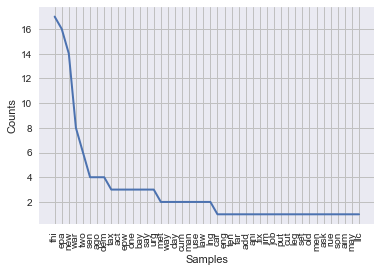

In [46]:
whcfdist[3].plot()

See that the most frequent 3-character word is "thi". But what is "thi"? It is actually "this" stemmed by the Porter Stemmer. 

In [47]:
porter = nltk.stem.porter.PorterStemmer()
print (porter.stem('this'))

thi


Let's try with the Snowball Stemer. See that "this" is corretly stemmed as a 4-character word. 

this


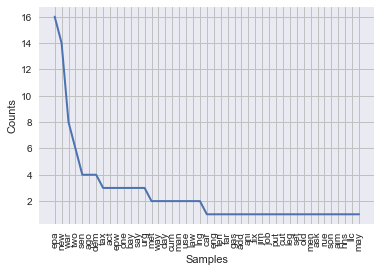

In [48]:
print (snowball.stem('this'))

whReleases['normalized_tokens'] = whReleases['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))
whReleases['normalized_tokens_count'] = whReleases['normalized_tokens'].apply(lambda x: len(x))
whcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in whReleases['normalized_tokens'].sum()))
whcfdist[3].plot()

We can also create a Conditional Probability Distribution or [`ConditionalProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ConditionalProbDist) from the `ConditionalFreqDist`. To do this, however, we need a model for the probability distribution. A simple model is [`ELEProbDist`](http://www.nltk.org/api/nltk.html#nltk.probability.ELEProbDist) which gives the expected likelihood estimate for the probability distribution of the experiment used to generate the observed frequency distribution. 

In [49]:
whcpdist = nltk.ConditionalProbDist(whcfdist, nltk.ELEProbDist)

#print the most common 2 letter word
print(whcpdist[2].max())

#And its probability
print(whcpdist[2].prob(whcpdist[2].max()))

us
0.6470588235294118


Length is one feature of a word, but there are many more important features we care about. Another critical feature is a word's role in the sentence, or its part of speech (POS). Here, we will be classifying words according to their part of speech (POS), using the [`nltk.pos_tag()`](http://www.nltk.org/api/nltk.tag.html#nltk.tag.pos_tag). The tags used here are those from the [Brown Corpus tagset](http://www.scs.leeds.ac.uk/amalgam/tagsets/brown.html).

In [50]:
whReleases['normalized_tokens_POS'] = [nltk.pos_tag(t) for t in whReleases['normalized_tokens']]

This gives us a new column with the part of speech as a short initialism and the word in a tuple, exactly how the `nltk.ConditionalFreqDist()` function wants them. We can now construct another conditional frequency distribution.

In [51]:
whcfdist_WordtoPOS = nltk.ConditionalFreqDist(whReleases['normalized_tokens_POS'].sum())
list(whcfdist_WordtoPOS.items())[:10]

[('yard', FreqDist({'RB': 1})),
 ('mere', FreqDist({'JJ': 1})),
 ('celebr', FreqDist({'NN': 1})),
 ('statewid', FreqDist({'JJ': 1})),
 ('child', FreqDist({'NN': 1})),
 ('expect', FreqDist({'VBP': 1})),
 ('strongest', FreqDist({'JJS': 2})),
 ('far', FreqDist({'RB': 1})),
 ('environment', FreqDist({'NN': 3})),
 ('offic', FreqDist({'JJ': 1}))]

This gives the frequency of each word as each part of speech...which can be uninformative and boring.

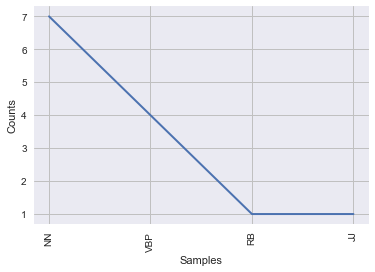

In [52]:
whcfdist_WordtoPOS['administr'].plot()

What we want is the converse; the frequency of each part of speech for each word.

In [53]:
whcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in whReleases['normalized_tokens_POS'].sum())

We can now identify and collect all of the superlative adjectives

In [54]:
whcfdist_POStoWord['JJS']

FreqDist({'best': 1, 'strongest': 2})

Or look at the most common nouns

In [55]:
whcfdist_POStoWord['NN'].most_common(5)

[('bush', 24), ('presid', 23), ('iraq', 22), ('island', 18), ('rhode', 18)]

Or plot the base form verbs against their number of occurrences

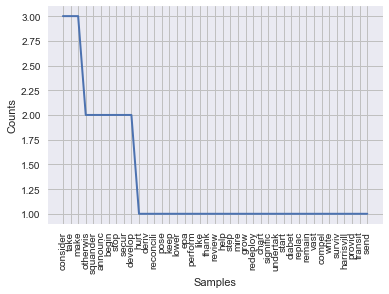

In [56]:
whcfdist_POStoWord['VB'].plot()

We can then do a similar analysis of the word probabilities

In [57]:
whcpdist_POStoWord = nltk.ConditionalProbDist(whcfdist_POStoWord, nltk.ELEProbDist)

#print the most common nouns
print(whcpdist_POStoWord['NN'].max())

#And its probability
print(whcpdist_POStoWord['NN'].prob(whcpdist_POStoWord['NN'].max()))

bush
0.01786365293474298


We can even create a...wait for it...*WORD CLOUD* or Wordl to gaze at and draw mystical, approximate inferences about important nouns and verbs in our corpus:

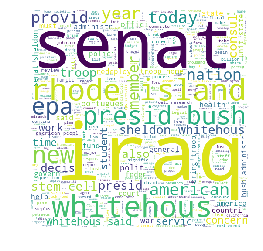

In [58]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(whReleases['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("whitehouse_word_cloud.pdf", format = 'pdf')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that filter, stem and lemmatize the tokens in your corpus, and then creates plots (with titles and labels) that map the word frequency distribution, word probability distribution, and at least two conditional probability distributions that help us better understand the social and cultural game underlying the production of your corpus. Create a wordl of words (or normalized words) and add a few vague comments about what mysteries are revealed through it.</span>

In [59]:
# Normalize Woody Allen text
## I inspected the frequency distribution of words to select a specific cut-off
## to remove 'meaningless words' and preserve 'meaningful words'
print(wacountedWords[:60])

    count   word
0    1051      ,
1     931      .
2     704    the
3     629     to
4     628    and
5     549      a
6     333     is
7     313    her
8     296     he
9     278     in
10    276     of
11    270    his
12    264   with
13    241   that
14    209    she
15    208     's
16    196      (
17    196      )
18    151    him
19    137    for
20    125   they
21    108     at
22    105     on
23     99    who
24     96    has
25     95     as
26     90    but
27     90     an
28     84     by
29     72     it
30     69  their
31     66     ``
32     64     ''
33     60  after
34     53   from
35     52   when
36     51  about
37     50    not
38     48     up
39     47   love
40     45    new
41     45    out
42     44    had
43     41   have
44     41   into
45     41  while
46     39    was
47     39    c.w
48     38    gil
49     38    are
50     37  where
51     37   life
52     37   film
53     36     be
54     35   been
55     35    one
56     35   back
57     35   th

In [60]:
## It seems reasonable to remove words more frequent than the most frequent verb "love" (other than "has")
## The stop list is then all words that occur before "love"
wa_cut_off = wacountedWords.loc[wacountedWords['word'] == 'love'].index[0]
wa_stop_words = wacountedWords['word'][:wa_cut_off].tolist()
print(wa_stop_words)

[',', '.', 'the', 'to', 'and', 'a', 'is', 'her', 'he', 'in', 'of', 'his', 'with', 'that', 'she', "'s", '(', ')', 'him', 'for', 'they', 'at', 'on', 'who', 'has', 'as', 'but', 'an', 'by', 'it', 'their', '``', "''", 'after', 'from', 'when', 'about', 'not', 'up']


In [61]:
## Normalize tokens
waTokens_nor = normlizeTokens(waTokens, stopwordLst = wa_stop_words, stemmer = porter)
print('Original number of Tokens:', len(waTokens), '\nAfter normalization:', len(waTokens_nor))

Original number of Tokens: 20040 
After normalization: 10759


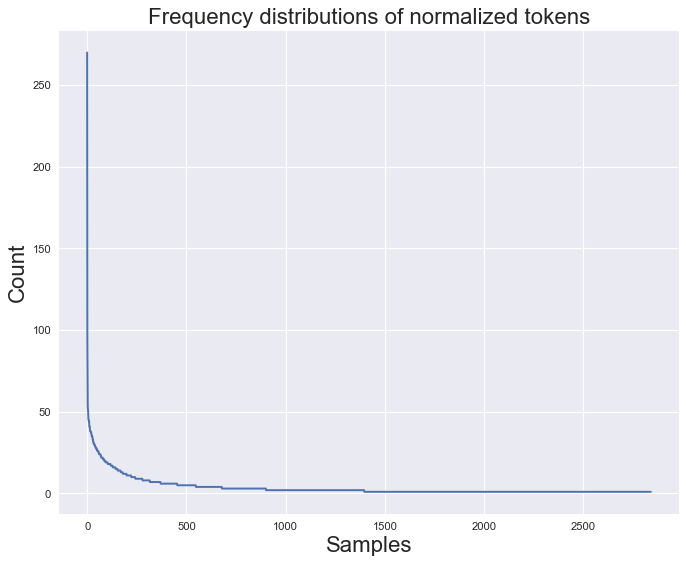

In [62]:
## Count, sort and plot word frequency distribution
wacountedWords_nor = wordCounter(waTokens_nor)
wacountedWords_nor.sort_values('count', ascending=False, inplace=True)
wacountedWords_nor = wacountedWords_nor.reset_index(drop=True)

fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')                                                              
ax = fig.add_subplot(111)                                                       
plt.title(r'Frequency distributions of normalized tokens', size=20)
plt.xlabel(r'Samples', size=20)                                                             
plt.ylabel(r'Count', size=20) 
plt.tick_params(labelsize=10)
plt.plot(range(len(wacountedWords_nor)), wacountedWords_nor['count'])

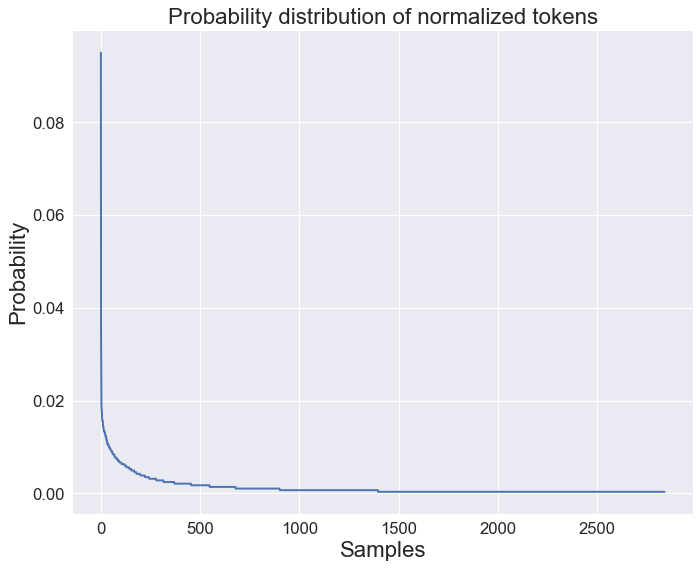

In [63]:
## Plot word probability distribution
fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')                                                              
ax = fig.add_subplot(111)                                                       
plt.title(r'Probability distribution of normalized tokens', size = 20)
plt.xlabel(r'Samples', size = 20)                                                             
plt.ylabel(r'Probability', size = 20) 
plt.tick_params(labelsize=15)
plt.plot(range(len(wacountedWords_nor)), wacountedWords_nor['count'] / len(wacountedWords_nor))

In [64]:
# Normalize Alfred Hitchcock text
## Inspect to select a specific cut-off to remove 'meaningless words' and preserve 'meaningful words'
print(ahcountedWords[:60])

    count    word
0    1749     the
1    1719       ,
2    1480       .
3    1025      to
4     862     and
5     735       a
6     498      is
7     468      he
8     438     her
9     427      of
10    407      in
11    370     his
12    344    that
13    340      's
14    290     she
15    264       (
16    264       )
17    217    with
18    208     him
19    180     for
20    177      at
21    175      as
22    172    they
23    168      by
24    168     but
25    154      on
26    149     has
27    132      ``
28    132      ''
29    129     who
30    127    when
31    120    from
32    115     are
33    109      an
34     98  police
35     96     was
36     87     not
37     86     out
38     85      it
39     81      be
40     79   their
41     75       ;
42     70      up
43     69   after
44     68   tells
45     63    will
46     62    then
47     61    into
48     58    them
49     57     guy
50     57   about
51     54     had
52     51  father
53     50   while
54     49 

In [65]:
## It seems reasonable to remove words more frequent than the most frequent noun "police"
## The stop list is then all words that occur before "police"
ah_cut_off = ahcountedWords.loc[ahcountedWords['word'] == 'police'].index[0]
ah_stop_words = ahcountedWords['word'][:ah_cut_off].tolist()
print(ah_stop_words)

['the', ',', '.', 'to', 'and', 'a', 'is', 'he', 'her', 'of', 'in', 'his', 'that', "'s", 'she', '(', ')', 'with', 'him', 'for', 'at', 'as', 'they', 'by', 'but', 'on', 'has', '``', "''", 'who', 'when', 'from', 'are', 'an']


In [66]:
## Normalize tokens
ahTokens_nor = normlizeTokens(ahTokens, stopwordLst = ah_stop_words, stemmer = porter)
print('Original number of Tokens:', len(ahTokens), '\nAfter normalization:', len(ahTokens_nor))

Original number of Tokens: 31711 
After normalization: 17465


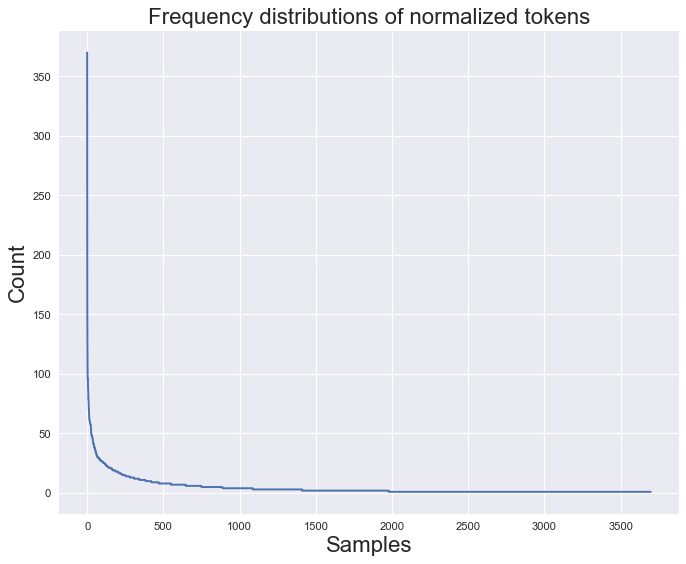

In [67]:
## Count, sort and plot word frequency distribution
ahcountedWords_nor = wordCounter(ahTokens_nor)
ahcountedWords_nor.sort_values('count', ascending=False, inplace=True)
ahcountedWords_nor = ahcountedWords_nor.reset_index(drop=True)

fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')                                                              
ax = fig.add_subplot(111)                                                       
plt.title(r'Frequency distributions of normalized tokens', size=20)
plt.xlabel(r'Samples', size=20)                                                             
plt.ylabel(r'Count', size=20) 
plt.tick_params(labelsize=10)
plt.plot(range(len(ahcountedWords_nor)), ahcountedWords_nor['count'])

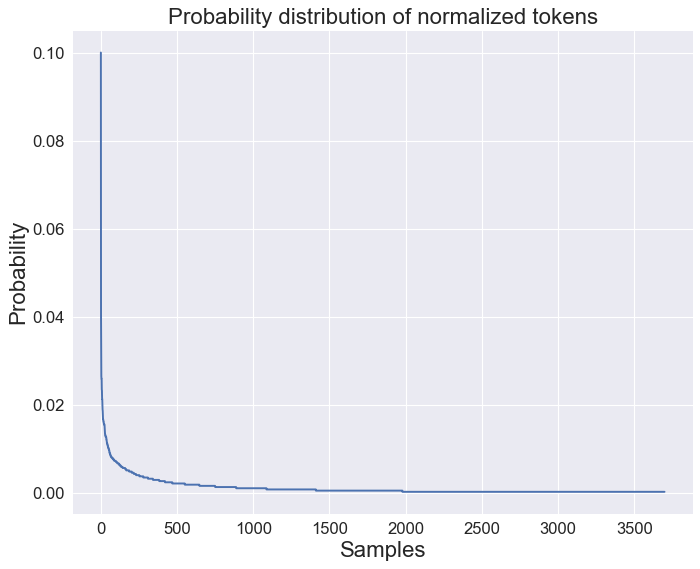

In [68]:
## Plot word probability distribution
fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')                                                              
ax = fig.add_subplot(111)                                                       
plt.title(r'Probability distribution of normalized tokens', size = 20)
plt.xlabel(r'Samples', size = 20)                                                             
plt.ylabel(r'Probability', size = 20) 
plt.tick_params(labelsize=15)
plt.plot(range(len(ahcountedWords_nor)), ahcountedWords_nor['count'] / len(ahcountedWords_nor))

In [69]:
# Analyze the normalized Woody Allen text
## Conditional frequency distributions with word lengths as the conditions
wacfdist = nltk.ConditionalFreqDist(((len(w), w) for w in waTokens_nor))
## Print the number of words
print(wacfdist.N())

10759


In [70]:
import operator
print('Most frequent 20 words of length 2:')
print(sorted(wacfdist[2].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 3:')
print(sorted(wacfdist[3].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 4:')
print(sorted(wacfdist[4].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 5:')
print(sorted(wacfdist[5].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 6:')
print(sorted(wacfdist[6].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 7:')
print(sorted(wacfdist[7].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 8:')
print(sorted(wacfdist[8].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 9:')
print(sorted(wacfdist[9].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 10:')
print(sorted(wacfdist[10].items(), key = operator.itemgetter(1), reverse = True)[:20])

Most frequent 20 words of length 2:
[('hi', 270), ('ha', 96), ('be', 50), ('wa', 39), ('go', 30), ('if', 17), ('no', 16), ('so', 15), ('or', 11), ('do', 11), ('al', 10), ('lo', 3), ('ed', 2), ('ca', 1), ('au', 1), ('bu', 1), ('me', 1), ('ad', 1), ('de', 1)] 

Most frequent 20 words of length 3:
[('new', 45), ('out', 45), ('had', 44), ('get', 41), ('gil', 38), ('are', 38), ('one', 35), ('ask', 34), ('two', 30), ('ann', 30), ('goe', 29), ('end', 28), ('thi', 26), ('see', 26), ('doe', 25), ('say', 24), ('tri', 23), ('now', 22), ('can', 21), ('ray', 20)] 

Most frequent 20 words of length 4:
[('have', 69), ('love', 53), ('find', 52), ('tell', 46), ('leav', 44), ('into', 41), ('meet', 38), ('film', 38), ('life', 37), ('been', 35), ('then', 35), ('back', 35), ('paul', 33), ('jack', 29), ('them', 29), ('will', 28), ('wife', 27), ('take', 26), ('make', 26), ('bori', 25)] 

Most frequent 20 words of length 5:
[('while', 41), ('becom', 38), ('where', 37), ('marri', 36), ('decid', 33), ('harri', 

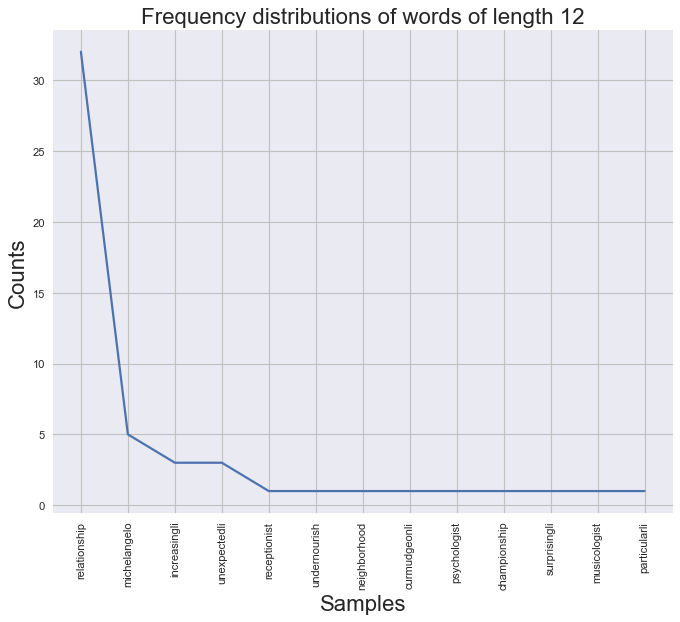

In [71]:
## Frequency distributions of words of length 12
fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')                                                              
ax = fig.add_subplot(111)                                                       
plt.title(r'Frequency distributions of words of length 12', size=20)
plt.xlabel(r'Samples', size=20)                                                             
plt.ylabel(r'Count', size=20) 
plt.tick_params(labelsize=10)
wacfdist[12].plot()

In [72]:
## Conditional Probability Distribution with ELE probability distribution
wacpdist = nltk.ConditionalProbDist(wacfdist, nltk.ELEProbDist)

print('The most common 2 letter word:', wacpdist[2].max())
print('probability:', wacpdist[2].prob(wacpdist[2].max()), '\n')

print('The most common 3 letter word:', wacpdist[3].max())
print('probability:', wacpdist[3].prob(wacpdist[3].max()), '\n')

print('The most common 4 letter word:', wacpdist[4].max())
print('probability:', wacpdist[4].prob(wacpdist[4].max()), '\n')

print('The most common 5 letter word:', wacpdist[5].max())
print('probability:', wacpdist[5].prob(wacpdist[5].max()), '\n')

print('The most common 6 letter word:', wacpdist[6].max())
print('probability:', wacpdist[6].prob(wacpdist[6].max()), '\n')

print('The most common 7 letter word:', wacpdist[7].max())
print('probability:', wacpdist[7].prob(wacpdist[7].max()), '\n')

The most common 2 letter word: hi
probability: 0.46199829205807 

The most common 3 letter word: new
probability: 0.033917256802087216 

The most common 4 letter word: have
probability: 0.022081016679904687 

The most common 5 letter word: while
probability: 0.014776571123375467 

The most common 6 letter word: return
probability: 0.015997968511934992 

The most common 7 letter word: antonio
probability: 0.02502050861361772 



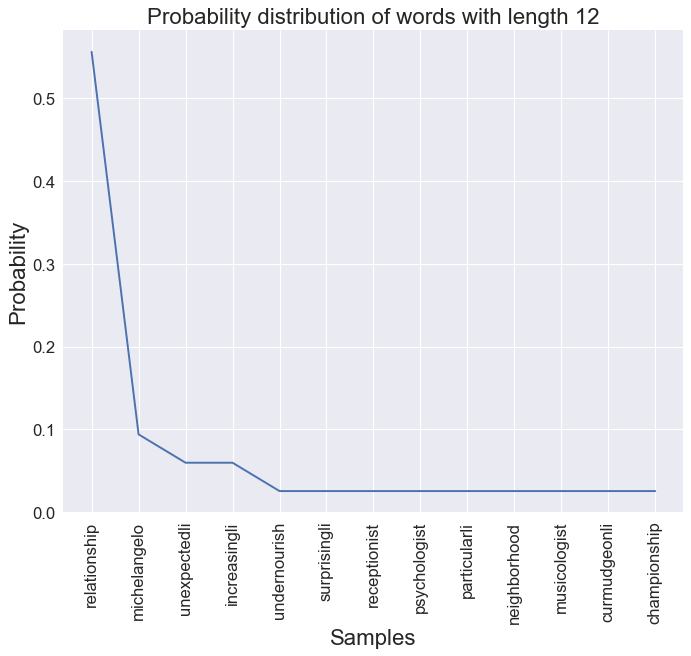

In [73]:
def plotCPD(cpdist, length):
    sample_words = list(cpdist[length].samples())
    sample_prob = []
    for word in sample_words:
        sample_prob.append(cpdist[length].prob(word))
    sample_probs, sample_words = zip(*sorted(zip(sample_prob, sample_words)))
    words = np.array(list(reversed(sample_words)))
    probs = np.array(list(reversed(sample_probs)))
    fake_x = np.array(range(len(words)))
    
    fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')                                                              
    ax = fig.add_subplot(111)                                                       
    plt.title(r'Probability distribution of words with length {}'.format(length), size = 20)
    plt.xlabel(r'Samples', size = 20)                                                             
    plt.ylabel(r'Probability', size = 20) 
    plt.tick_params(labelsize=15)
    plt.xticks(fake_x, words, rotation='vertical')
    plt.plot(fake_x, probs)
    plt.show()

plotCPD(wacpdist, 12)

In [74]:
## Classify words according to their part of speech (POS)
waTokens_norPOS = nltk.pos_tag(waTokens_nor)
print(waTokens_norPOS)

[('virgil', 'NN'), ('starkwel', 'NN'), ('woodi', 'NN'), ('allen', 'NN'), ('stori', 'NN'), ('told', 'VBD'), ('documentari', 'JJ'), ('style', 'NN'), ('use', 'IN'), ('both', 'DT'), ('stock', 'NN'), ('footag', 'NN'), ('interview', 'NN'), ('peopl', 'VBP'), ('knew', 'VB'), ('begin', 'JJ'), ('life', 'NN'), ('crime', 'NN'), ('young', 'JJ'), ('age', 'NN'), ('child', 'NN'), ('virgil', 'FW'), ('frequent', 'JJ'), ('target', 'NN'), ('bulli', 'NN'), ('snatch', 'NN'), ('hi', 'NN'), ('glass', 'NN'), ('stomp', 'VBD'), ('them', 'PRP'), ('floor', 'NN'), ('adult', 'NN'), ('virgil', 'NN'), ('inept', 'NN'), ('unlucki', 'JJ'), ('both', 'DT'), ('polic', 'JJ'), ('judg', 'NN'), ('ridicul', 'NN'), ('stomp', 'NN'), ('virgil', 'NN'), ('glass', 'NN'), ('virgil', 'NN'), ('fall', 'NN'), ('love', 'NN'), ('young', 'JJ'), ('ladi', 'NN'), ('louis', 'JJ'), ('janet', 'NN'), ('margolin', 'NN'), ('laundri', 'JJ'), ('worker', 'NN'), ('live', 'VBP'), ('togeth', 'RB'), ('even', 'RB'), ('have', 'VBP'), ('babi', 'VBN'), ('virgil'

In [75]:
## Conditional frequency distribution with POS as the conditions
wacfdist_WordtoPOS = nltk.ConditionalFreqDist(waTokens_norPOS)
list(wacfdist_WordtoPOS.items())[:10]

[('off', FreqDist({'IN': 5, 'RP': 10})),
 ('copi', FreqDist({'NN': 1})),
 ('mere', FreqDist({'JJ': 1, 'RB': 1})),
 ('whim', FreqDist({'NN': 2})),
 ('watch', FreqDist({'NN': 6, 'VB': 1})),
 ('trap', FreqDist({'JJ': 1})),
 ('crimin', FreqDist({'NN': 6})),
 ('citi', FreqDist({'JJ': 2, 'NN': 12})),
 ('tree', FreqDist({'VBP': 1})),
 ('aka', FreqDist({'RB': 1}))]

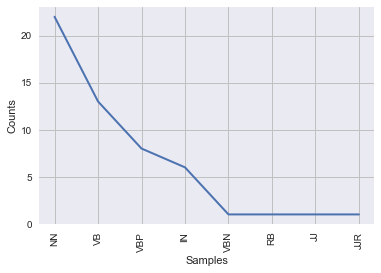

In [76]:
## The frequency of word "love" as each part of speech
wacfdist_WordtoPOS['love'].plot()

In [77]:
## Compute the frequency of each part of speech for each word
wacfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in waTokens_norPOS)

In [78]:
print('Most common adjectives:')
print(wacfdist_POStoWord['JJS'].most_common(5), '\n')

print('Most common nouns:')
print(wacfdist_POStoWord['NN'].most_common(20), '\n')

print('Most common verbs:')
print(wacfdist_POStoWord['VB'].most_common(15))

Most common adjectives:
[('best', 7), ('latest', 3), ('arrest', 2), ('most', 2), ('manifest', 1)] 

Most common nouns:
[('hi', 179), ('ha', 72), ('film', 38), ('life', 37), ('meet', 35), ('relationship', 32), ('gil', 29), ('jack', 28), ('harri', 27), ('wife', 27), ('wa', 26), ('becom', 26), ('paul', 25), ('time', 24), ('return', 24), ('marriag', 23), ('decid', 23), ('love', 22), ('goe', 22), ('night', 21)] 

Most common verbs:
[('be', 50), ('get', 21), ('take', 15), ('kill', 14), ('find', 13), ('love', 13), ('give', 10), ('feel', 9), ('ask', 9), ('begin', 9), ('see', 9), ('go', 8), ('run', 8), ('make', 8), ('have', 6)]


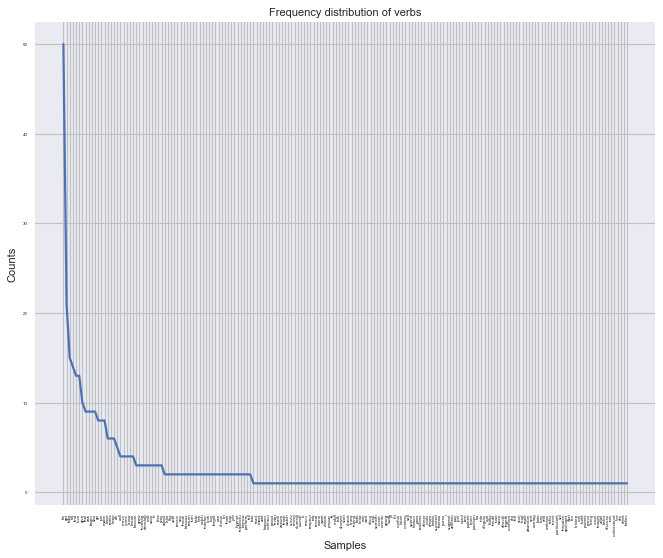

In [79]:
## Frequency distribution of verbs
fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')                                                              
ax = fig.add_subplot(111)                                                       
plt.title(r'Frequency distribution of verbs', size=10)
plt.xlabel(r'Samples', size=10)                                                             
plt.ylabel(r'Count', size=10) 
plt.tick_params(labelsize=4)
wacfdist_POStoWord['VB'].plot()

In [80]:
## Conditional Probability Distribution with ELE probability distribution
wacpdist_POStoWord = nltk.ConditionalProbDist(wacfdist_POStoWord, nltk.ELEProbDist)

print('The most common adjective:', wacpdist_POStoWord['JJS'].max())
print('probability:', wacpdist_POStoWord['JJS'].prob(wacpdist_POStoWord['JJS'].max()), '\n')

print('The most common noun:', wacpdist_POStoWord['NN'].max())
print('probability:', wacpdist_POStoWord['NN'].prob(wacpdist_POStoWord['NN'].max()), '\n')

print('The most common verb:', wacpdist_POStoWord['VB'].max())
print('probability:', wacpdist_POStoWord['VB'].prob(wacpdist_POStoWord['VB'].max()))

The most common adjective: best
probability: 0.20270270270270271 

The most common noun: hi
probability: 0.02743180255215099 

The most common verb: be
probability: 0.09519321394910461


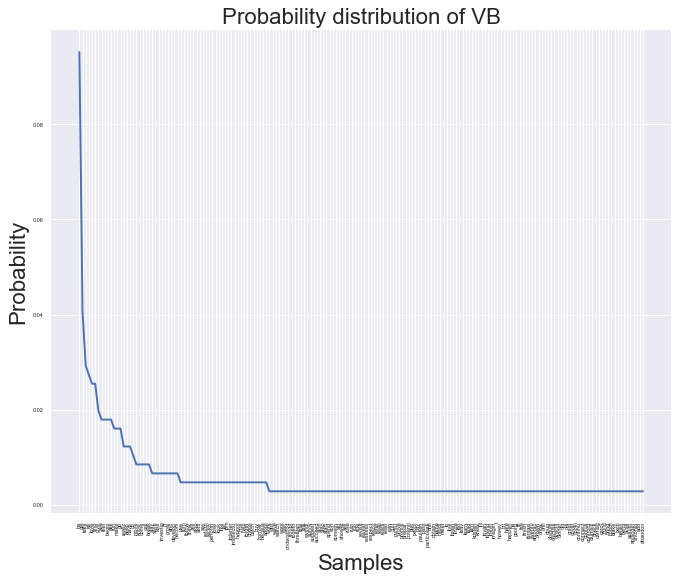

In [81]:
def plotCPD_POS(cpdist, POS_type):
    sample_words = list(cpdist[POS_type].samples())
    sample_prob = []
    for word in sample_words:
        sample_prob.append(cpdist[POS_type].prob(word))
    sample_probs, sample_words = zip(*sorted(zip(sample_prob, sample_words)))
    words = np.array(list(reversed(sample_words)))
    probs = np.array(list(reversed(sample_probs)))
    fake_x = np.array(range(len(words)))
    
    fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')                                                              
    ax = fig.add_subplot(111)                                                       
    plt.title(r'Probability distribution of {}'.format(POS_type), size = 20)
    plt.xlabel(r'Samples', size = 20)                                                             
    plt.ylabel(r'Probability', size = 20) 
    plt.tick_params(labelsize=5)
    plt.xticks(fake_x, words, rotation='vertical')
    plt.plot(fake_x, probs)
    plt.show()

plotCPD_POS(wacpdist_POStoWord, 'VB')

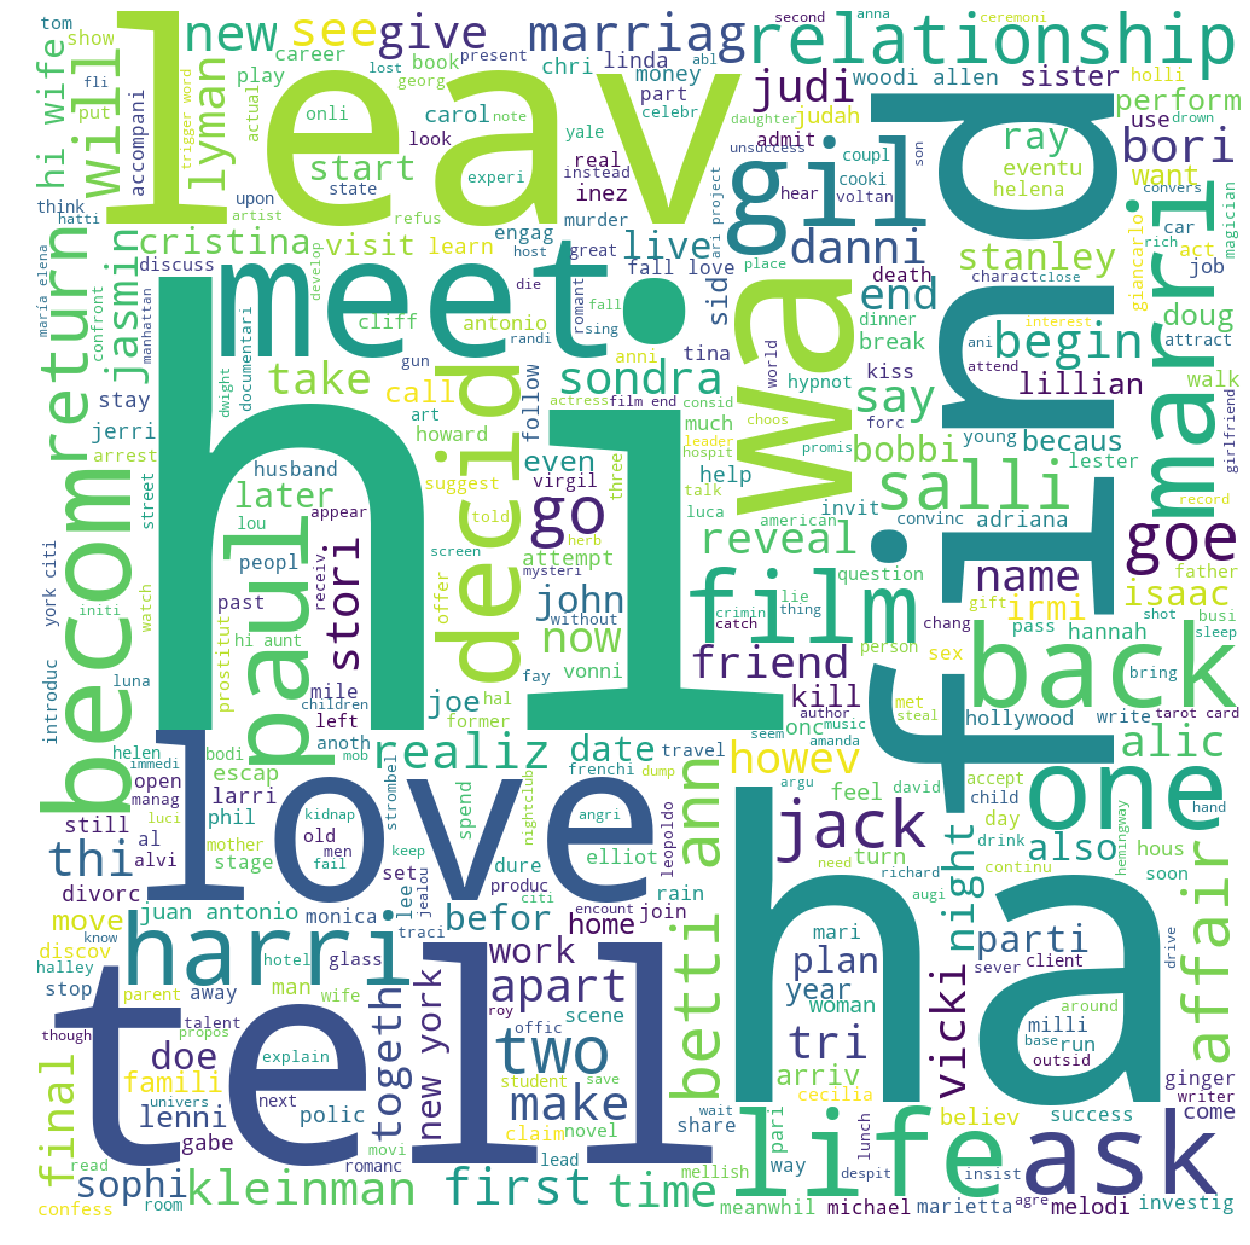

In [82]:
## Draw a Word Cloud about important words in our corpus
wa_wc = wordcloud.WordCloud(background_color="white", max_words=400, width=2000, height=2000, mode='RGBA', scale=.5).generate(' '.join(waTokens_nor))
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')  
plt.imshow(wa_wc)
plt.axis("off")
plt.savefig("wa_word_cloud.pdf", format='pdf')

It seems that "tell", "love", "find", "leave", "meet", "decide", "become", "ask", "back" are pretty important actions in Woody Allen's comedies and "life" and "marriage" are frequently mentioned. It indicates that most of these films are set in family, and talk a lot about kinship, friendship, and relationship, which makes sense as they are all comedies!

In [83]:
# Analyze the normalized Alfred Hitchcock text
## Conditional frequency distributions with word lengths as the conditions
ahcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in ahTokens_nor))

print('Most frequent 20 words of length 2:')
print(sorted(ahcfdist[2].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 3:')
print(sorted(ahcfdist[3].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 4:')
print(sorted(ahcfdist[4].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 5:')
print(sorted(ahcfdist[5].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 6:')
print(sorted(ahcfdist[6].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 7:')
print(sorted(ahcfdist[7].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 8:')
print(sorted(ahcfdist[8].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 9:')
print(sorted(ahcfdist[9].items(), key = operator.itemgetter(1), reverse = True)[:20], '\n')

print('Most frequent 20 words of length 10:')
print(sorted(ahcfdist[10].items(), key = operator.itemgetter(1), reverse = True)[:20])

Most frequent 20 words of length 2:
[('hi', 370), ('ha', 149), ('be', 116), ('it', 96), ('wa', 96), ('up', 70), ('go', 47), ('so', 30), ('do', 26), ('no', 23), ('if', 22), ('or', 17), ('de', 16), ('jo', 15), ('bu', 9), ('we', 9), ('gu', 4), ('mr', 4), ('me', 4), ('my', 3)] 

Most frequent 20 words of length 3:
[('not', 87), ('out', 86), ('see', 60), ('guy', 57), ('had', 54), ('man', 49), ('say', 48), ('one', 47), ('two', 44), ('tri', 43), ('thi', 42), ('ask', 39), ('can', 38), ('get', 36), ('all', 31), ('car', 31), ('sam', 31), ('new', 30), ('goe', 29), ('off', 28)] 

Most frequent 20 words of length 4:
[('tell', 79), ('leav', 72), ('will', 65), ('then', 62), ('into', 61), ('kill', 60), ('take', 59), ('have', 58), ('find', 58), ('them', 58), ('been', 49), ('wife', 47), ('hous', 42), ('miss', 40), ('john', 38), ('back', 37), ('dure', 36), ('fall', 34), ('next', 33), ('room', 33)] 

Most frequent 20 words of length 5:
[('polic', 98), ('their', 79), ('after', 69), ('about', 57), ('while',

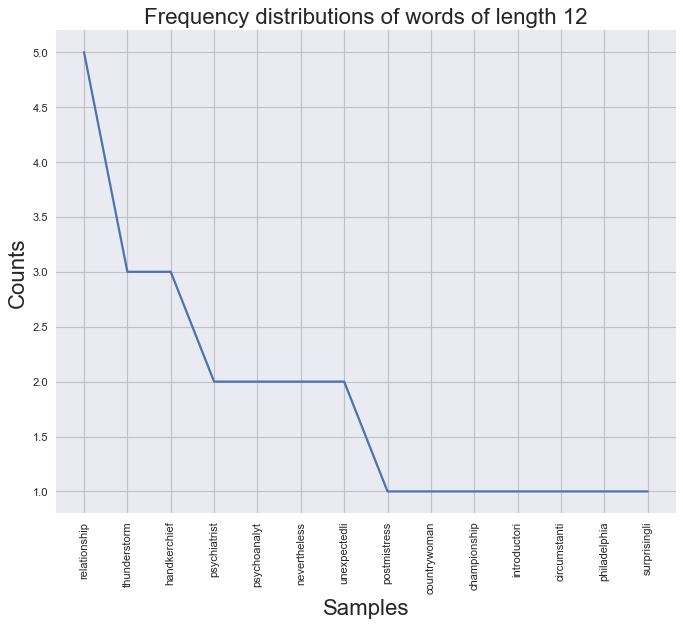

In [84]:
## Frequency distributions of words of length 12
fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')                                                              
ax = fig.add_subplot(111)                                                       
plt.title(r'Frequency distributions of words of length 12', size=20)
plt.xlabel(r'Samples', size=20)                                                             
plt.ylabel(r'Count', size=20) 
plt.tick_params(labelsize=10)
ahcfdist[12].plot()

In [85]:
## Conditional Probability Distribution with ELE probability distribution
ahcpdist = nltk.ConditionalProbDist(ahcfdist, nltk.ELEProbDist)

print('The most common 2 letter word:', ahcpdist[2].max())
print('probability:', ahcpdist[2].prob(ahcpdist[2].max()), '\n')

print('The most common 3 letter word:', ahcpdist[3].max())
print('probability:', ahcpdist[3].prob(ahcpdist[3].max()), '\n')

print('The most common 4 letter word:', ahcpdist[4].max())
print('probability:', ahcpdist[4].prob(ahcpdist[4].max()), '\n')

print('The most common 5 letter word:', ahcpdist[5].max())
print('probability:', ahcpdist[5].prob(ahcpdist[5].max()), '\n')

print('The most common 6 letter word:', ahcpdist[6].max())
print('probability:', ahcpdist[6].prob(ahcpdist[6].max()), '\n')

print('The most common 7 letter word:', ahcpdist[7].max())
print('probability:', ahcpdist[7].prob(ahcpdist[7].max()), '\n')

The most common 2 letter word: hi
probability: 0.3210571923743501 

The most common 3 letter word: not
probability: 0.044102822580645164 

The most common 4 letter word: tell
probability: 0.01687181663837012 

The most common 5 letter word: polic
probability: 0.022875058058522992 

The most common 6 letter word: murder
probability: 0.018913602663035253 

The most common 7 letter word: attempt
probability: 0.014846502264720684 



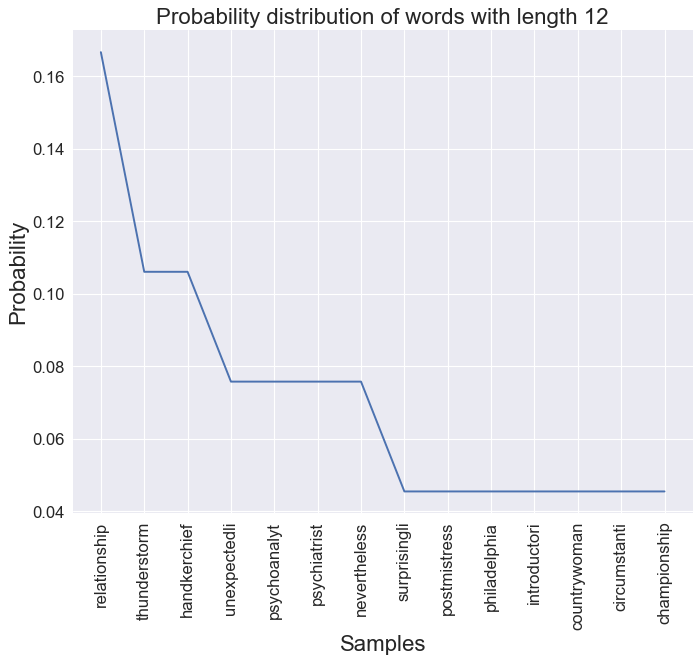

In [86]:
plotCPD(ahcpdist, 12)

In [87]:
## Classify words according to their part of speech (POS)
ahTokens_norPOS = nltk.pos_tag(ahTokens_nor)

## Conditional frequency distribution with POS as the conditions
ahcfdist_WordtoPOS = nltk.ConditionalFreqDist(ahTokens_norPOS)
print(list(ahcfdist_WordtoPOS.items())[:10])

## Compute the frequency of each part of speech for each word
ahcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in ahTokens_norPOS)

[('off', FreqDist({'RP': 19, 'IN': 9})), ('copi', FreqDist({'NN': 1})), ('mere', FreqDist({'JJ': 2})), ('wink', FreqDist({'NN': 1})), ('commodor', FreqDist({'NN': 5})), ('watch', FreqDist({'NN': 13, 'JJ': 1, 'VBP': 1, 'VB': 1})), ('trap', FreqDist({'NN': 2, 'VB': 1})), ('media', FreqDist({'NNS': 1})), ('shrink', FreqDist({'VB': 1})), ('crimin', FreqDist({'NN': 7, 'VBN': 1}))]


In [88]:
print('Most common adjectives:')
print(ahcfdist_POStoWord['JJS'].most_common(5), '\n')

print('Most common nouns:')
print(ahcfdist_POStoWord['NN'].most_common(20), '\n')

print('Most common verbs:')
print(ahcfdist_POStoWord['VB'].most_common(15), '\n')

Most common adjectives:
[('guest', 9), ('best', 4), ('forest', 3), ('most', 3), ('west', 2)] 

Most common nouns:
[('hi', 226), ('ha', 104), ('murder', 60), ('wa', 54), ('guy', 53), ('man', 49), ('wife', 47), ('leav', 41), ('return', 36), ('death', 34), ('father', 34), ('tell', 34), ('room', 33), ('john', 33), ('dure', 32), ('jack', 32), ('bruno', 31), ('car', 31), ('escap', 30), ('home', 29)] 

Most common verbs:
[('be', 116), ('take', 36), ('kill', 33), ('get', 28), ('tell', 21), ('go', 20), ('see', 18), ('find', 16), ('keep', 16), ('know', 13), ('run', 12), ('have', 10), ('begin', 10), ('love', 8), ('stop', 8)] 



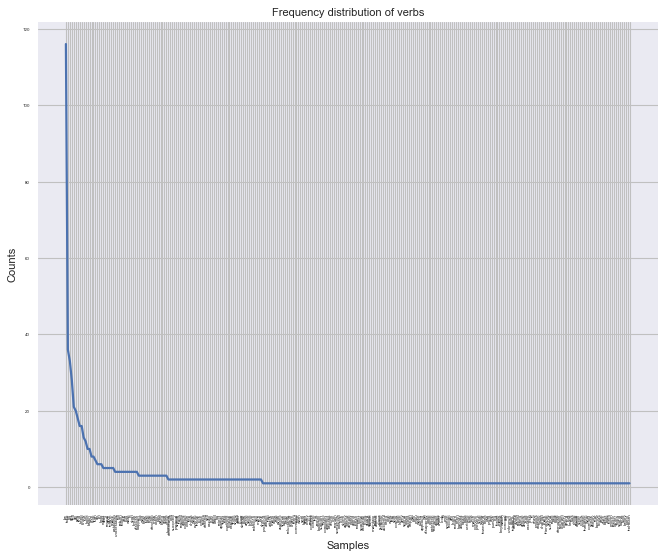

In [89]:
fig = plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')                                                              
ax = fig.add_subplot(111)                                                       
plt.title(r'Frequency distribution of verbs', size=10)
plt.xlabel(r'Samples', size=10)                                                             
plt.ylabel(r'Count', size=10) 
plt.tick_params(labelsize=4)
ahcfdist_POStoWord['VB'].plot()

In [90]:
## Conditional Probability Distribution with ELE probability distribution
ahcpdist_POStoWord = nltk.ConditionalProbDist(ahcfdist_POStoWord, nltk.ELEProbDist)

print('The most common adjective:', ahcpdist_POStoWord['JJS'].max())
print('probability:', ahcpdist_POStoWord['JJS'].prob(ahcpdist_POStoWord['JJS'].max()), '\n')

print('The most common noun:', ahcpdist_POStoWord['NN'].max())
print('probability:', ahcpdist_POStoWord['NN'].prob(ahcpdist_POStoWord['NN'].max()), '\n')

print('The most common verb:', ahcpdist_POStoWord['VB'].max())
print('probability:', ahcpdist_POStoWord['VB'].prob(ahcpdist_POStoWord['VB'].max()))

The most common adjective: guest
probability: 0.2289156626506024 

The most common noun: hi
probability: 0.022206970929947546 

The most common verb: be
probability: 0.1240021287919106


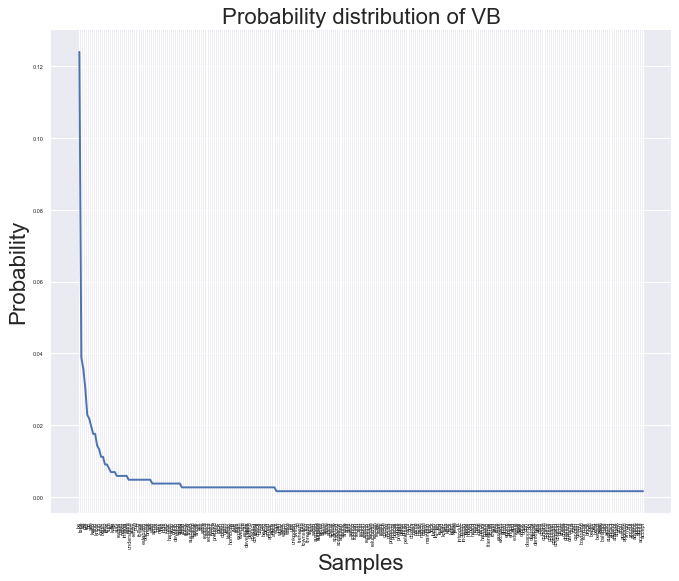

In [91]:
plotCPD_POS(ahcpdist_POStoWord, 'VB')

In [92]:
## Draw a Word Cloud about important words in our corpus
ah_wc = wordcloud.WordCloud(background_color="white", max_words=400, width=2000, height=2000, mode='RGBA', scale=.5).generate(' '.join(ahTokens_nor))
fig = plt.figure(figsize=(20, 20), dpi=600, facecolor='w', edgecolor='k')  
plt.imshow(ah_wc)
plt.axis("off")
plt.savefig("ah_word_cloud.pdf", format='pdf')

It seems that "murder", "tell", "leave", "kill", "go", "take", "find", "see" are pretty important actions in Alfred Hitchcock's thrillers and "police" and "guy" are frequently mentioned. It indicates that these films are related to crime, which makes sense as they are all thrillers!

# Collocations

As illustrated above, we might want to find significant bigrams (two-word phrases), trigrams (three-word phrases), n-grams (*n*-word phrases) or skip-grams (noncontinguous 'phrases' with skip-length *n*). We will begin with the [`nltk.collocations.BigramCollocationFinder`](http://www.nltk.org/api/nltk.html?highlight=bigramcollocationfinder#nltk.collocations.BigramCollocationFinder) class, which can be given raw lists of strings with the `from_words()` method. By default it only looks at continuous bigrams but there is an option (`window_size`) to allow skip-grams.

In [153]:
whBigrams = nltk.collocations.BigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(whBigrams.N))

There are 1999 bigrams in the finder


To compare the bigrams we need to tell nltk what our score function is. Initially, we will look at the raw counts.

In [154]:
def bigramScoring(count, wordsTuple, total):
    return count

print(whBigrams.nbest(bigramScoring, 10))

[('rhode', 'island'), ('presid', 'bush'), ('sheldon', 'whitehous'), ('stem', 'cell'), ('whitehous', 'said'), ('bush', 'administr'), ('american', 'peopl'), ('bring', 'troop'), ('senat', 'sheldon'), ('troop', 'home')]


One note about how `BigramCollocationFinder` works. It doesn't use the strings internally.

In [155]:
birgramScores = []

def bigramPrinting(count, wordsTuple, total):
    global birgramScores
    birgramScores.append("The first word is:  {}, The second word is: {}".format(*wordsTuple))
    #Returns None so all the tuples are considered to have the same rank

whBigrams.nbest(bigramPrinting, 10)
print('\n'.join(birgramScores[:10]))

The first word is:  9, The second word is: 2
The first word is:  13, The second word is: 1
The first word is:  28, The second word is: 40
The first word is:  1, The second word is: 5
The first word is:  1, The second word is: 14
The first word is:  12, The second word is: 4
The first word is:  6, The second word is: 8
The first word is:  14, The second word is: 4
The first word is:  1, The second word is: 1
The first word is:  20, The second word is: 1


The words are each given numeric IDs and there is a dictionary that maps the IDs to the words they represent. This is a common performance optimization.

Two words can appear together by chance. Recall from  Manning and Schütze's textbook that a $t-value$ can be computed for each bigram to see how significant the association is. You may also want to try computing the $\chi^2$, likelihood ratio, and pointwise mutual information statistics. 

In [156]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
whBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:40]
# other options include student_t, chi_sq, likelihood_ratio, pmi

[(('rhode', 'island'), 223.98603169548517),
 (('stem', 'cell'), 146.69971583676724),
 (('presid', 'bush'), 124.78339903371592),
 (('sheldon', 'whitehous'), 97.83057167237577),
 (('unit', 'state'), 63.7408597571739),
 (('whitehous', 'said'), 50.85365409523493),
 (('jack', 'reed'), 46.61449955206517),
 (('honor', 'societi'), 45.00623576992483),
 (('american', 'peopl'), 44.4949166648486),
 (('bring', 'troop'), 43.29082241816299),
 (('bush', 'administr'), 42.73672706610401),
 (('cell', 'research'), 41.25934273451902),
 (('youth', 'program'), 38.276119099832265),
 (('troop', 'home'), 36.87601441962918),
 (('come', 'home'), 36.661589434392276),
 (('senat', 'sheldon'), 36.08708619238288),
 (('epw', 'committe'), 34.42122395939712),
 (('potenti', 'close'), 33.7794434582587),
 (('budget', 'resolut'), 32.192797473966614),
 (('district', 'columbia'), 31.62701894759353),
 (('humpti', 'dumpti'), 31.62701894759353),
 (('jose', 'socrat'), 31.62701894759353),
 (('prime', 'minist'), 31.62701894759353),


There are a few other available measures

In [157]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

We can also look at trigrams

In [158]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
whTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(whReleases['normalized_tokens'].sum())
whTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('bring', 'troop', 'home'), 2.449202865677887),
 (('senat', 'sheldon', 'whitehous'), 2.4481166557834917),
 (('stem', 'cell', 'research'), 2.2359229352888974),
 (('whitehous', 'said', 'today'), 1.9987987990993996),
 (('jack', 'reed', 'sheldon'), 1.7319953264758123),
 (('senat', 'youth', 'program'), 1.7319901251233376),
 (('unit', 'state', 'senat'), 1.73173525885207),
 (('new', 'direct', 'iraq'), 1.7316624399174225),
 (('reed', 'sheldon', 'whitehous'), 1.7314959966382275),
 (('sheldon', 'whitehous', 'said'), 1.7309411857075774),
 (('trillion', 'foregon', 'surplus'), 1.414209315486583),
 (('reconsid', 'potenti', 'close'), 1.4142064842289084),
 (('sent', 'clear', 'messag'), 1.414205599460885),
 (('today', 'confirm', 'hear'), 1.4141976365486753),
 (('select', 'committe', 'intellig'), 1.4141965748270473),
 (('general', 'david', 'petraeus'), 1.4141923279405353),
 (('take', 'respons', 'secur'), 1.4141923279405353),
 (('cell', 'enhanc', 'act'), 1.4141880810540235),
 (('respons', 'secur', 'gov

Or n-grams (for any number n)

In [159]:
Ngrams = nltk.ngrams(whReleases['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('stem', 'cell', 'enhanc', 'act'): 2, ('jack', 'reed', 'sheldon', 'whitehous'): 3, ('member', 'senat', 'select', 'committe'): 2, ('american', 'citizen', 'rhode', 'island'): 2, ('senat', 'select', 'committe', 'intellig'): 2, ('portugues', 'american', 'citizen', 'rhode'): 2, ('stem', 'cell', 'research', 'whitehous'): 2, ('sheldon', 'whitehous', 'said', 'today'): 3, ('senat', 'jack', 'reed', 'sheldon'): 2, ('whitehous', 'welcom', 'rhode', 'island'): 2, ('begin', 'bring', 'troop', 'home'): 2, ('bring', 'troop', 'home', 'iraq'): 2, ('take', 'respons', 'secur', 'govern'): 2, ('senat', 'sheldon', 'whitehous', 'said'): 3}


## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify statistically significant bigrams, trigrams, quadgrams, higher-order *n*grams and skipgrams. Explore whether these collocations are idiomatic and so irreducible to the semantic sum of their component words. You can do this by examination of conditional frequencies (e.g., what else is 'united' besides the 'United States'). If these phrases are idiomatic, what do they suggest about the culture of the world producing them?

<span style="color:red">**Stretch**: In Manning and Schütze's textbook, there Section 5.3.2 explores how to use the *t*-test to find words whose co-occurance patterns best distinguish two words. Implement that and use it to explore phrases in your corpus. For instance, you could tell what words come after "America" much more often than after "Iraq"?</span> 

I took ngrams with t-value larger than 2.326 as statistically significant, with a significance level p < 0.01.

In [95]:
# Analyze Woody Allen text
## statistically significant bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
waBigrams = nltk.collocations.BigramCollocationFinder.from_words(waTokens_nor)
waBigrams_t = waBigrams.score_ngrams(bigram_measures.student_t)

In [97]:
def find_signficant_ngrams(ngrams_t):
    for ngram, t in ngrams_t:
        if t > 2.326:
            print(ngram, t)
        else:
            break

In [98]:
find_signficant_ngrams(waBigrams_t)

('betti', 'ann') 5.3691134394883795
('new', 'york') 4.340667653229368
('hi', 'wife') 4.203453205096915
('juan', 'antonio') 4.110932632075545
('woodi', 'allen') 3.7353975268462594
('had', 'been') 3.4227818170825444
('ha', 'been') 3.3739493284718405
('fall', 'love') 3.137353304226165
('york', 'citi') 2.819686051979408
('have', 'affair') 2.764939333071666
('hi', 'aunt') 2.739701950045768
('each', 'other') 2.6368985322563065
('find', 'out') 2.563546936416241
('trigger', 'word') 2.447668391547723
('tarot', 'card') 2.4473648330084803
('film', 'end') 2.409116457063915
('get', 'marri') 2.3934831922929223
('have', 'been') 2.357853008749325


In [104]:
# Examine the conditional frequency of component word in collocations
def find_following_gram(ngram_t):
    # Group ngrams by first word in ngram                                      
    prefix_keys = nltk.collections.defaultdict(list)
    for key, scores in ngram_t:
        prefix_keys[key[0]].append((key[1:], scores))

    # Sort keyed ngrams by strongest association                                
    for key in prefix_keys:
        prefix_keys[key].sort(key = lambda x: -x[1])
    return prefix_keys

In [113]:
# Explore whether these collocations are idiomatic
print('new', find_following_gram(waBigrams_t)['new'][:5], '\n')
print('hi', find_following_gram(waBigrams_t)['hi'][:5], '\n')
print('find', find_following_gram(waBigrams_t)['find'][:5], '\n')
print('fall', find_following_gram(waBigrams_t)['fall'][:5], '\n')
print('york', find_following_gram(waBigrams_t)['york'][:5], '\n')
print('have', find_following_gram(waBigrams_t)['have'][:5], '\n')
print('each', find_following_gram(waBigrams_t)['each'][:5], '\n')
print('find', find_following_gram(waBigrams_t)['find'][:5], '\n')
print('trigger', find_following_gram(waBigrams_t)['trigger'][:5], '\n')
print('tarot', find_following_gram(waBigrams_t)['tarot'][:5], '\n')
print('get', find_following_gram(waBigrams_t)['get'][:5])

new [(('york',), 4.340667653229368), (('year',), 1.9581745515382472), (('jersey',), 1.7248064273903665), (('girlfriend',), 1.7175620472118556), (('relationship',), 1.3195733760259782)] 

hi [(('wife',), 4.203453205096915), (('aunt',), 2.739701950045768), (('life',), 2.0704210169040085), (('fiancé',), 1.9372618273073705), (('client',), 1.8996189236917929)] 

find [(('out',), 2.563546936416241), (('no',), 1.6874039608390914), (('himself',), 1.681823104997868), (('melodi',), 1.3595325658169832), (('grin',), 0.9951668370666419)] 

fall [(('love',), 3.137353304226165), (('asleep',), 0.9985128729435822), (('ill',), 0.9985128729435822), (('kitti',), 0.9985128729435822), (('deepli',), 0.9970257458871642)] 

york [(('citi',), 2.819686051979408), (('distraught',), 0.9982340366205038), (('housewif',), 0.9982340366205038), (('vex',), 0.9982340366205038), (('carnegi',), 0.9964680732410075)] 

have [(('affair',), 2.764939333071666), (('been',), 2.357853008749325), (('sex',), 2.2045190306660256), (('

We can observe that among these statistically significant bigrams, besides those names such as "betti ann" and "new york" and nonsemantic phrases such as "had been" and "ha been", there are several collocations which are idiomatic and are interesting to observe in this corpora. They are: "fall love", "have affair", "trigger word", "tarot card", "get marri" (probably "get married"). Apparently, the corpora containing these collocations is about romance, relationship, affair, love, family.

In [115]:
## statistically significant trigrams
trigram_measures = nltk.collocations.TrigramAssocMeasures()
waTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(waTokens_nor)
waTrigrams_t = waTrigrams.score_ngrams(trigram_measures.student_t)
find_signficant_ngrams(waTrigrams_t)

('new', 'york', 'citi') 2.8283905648173393


In [116]:
# Explore whether these collocations are idiomatic
print('new', find_following_gram(waTrigrams_t)['new'][:5])

new [(('york', 'citi'), 2.8283905648173393), (('year', 'eve'), 1.4142025669057714), (('worldview', 'taken'), 0.9999980562576233), (('girlfriend', 'cocktail'), 0.999997667509148), (('prestigi', 'talent'), 0.9999972787606726)]


"new york citi" as an idiomatic collocation might suggest that most stories in Woody Allen's comedies are set in real world and many happen in New York City.

In [128]:
## statistically significant quadgrams
from nltk.metrics.association import QuadgramAssocMeasures
quadgram_measures = QuadgramAssocMeasures()
waQuadgrams = nltk.collocations.QuadgramCollocationFinder.from_words(waTokens_nor)
waQuadgrams_t = waQuadgrams.score_ngrams(quadgram_measures.student_t)
print(waQuadgrams_t[:10])

[(('unsur', 'what', 'want', 'life'), 1.4142135448109612), (('what', 'want', 'life', 'or'), 1.4142134657813592), (('want', 'life', 'or', 'love'), 1.4142132929329898), (('realiz', 'are', 'still', 'love'), 1.4142131164157175), (('hi', 'aunt', 'vanessa', 'ha'), 1.4142126793836194), (('agenc', 'repres', 'countless', 'unorthodox'), 0.9999999999991971), (('benito', 'mussolini', 'address', 'throng'), 0.9999999999991971), (('canova', 'nick', 'apollo', 'fort'), 0.9999999999991971), (('emilio', 'molina', 'varga', 'carlo'), 0.9999999999991971), (('fictiti', 'rko', 'radio', 'pictur'), 0.9999999999991971)]


There are no statistically significant quadgrams in this corpora.

In [132]:
## statistically significant pentagrams
waPentagrams = nltk.ngrams(waTokens_nor, 5)
waCounts = {}
for ngram in list(waPentagrams):
    if ngram in waCounts.keys():
        waCounts[ngram] += 1
    else:
        waCounts[ngram] = 1

## pentagrams occuring with more than twice
waFiltered = {}
for key in waCounts.keys():
    if waCounts[key] < 2:
        pass
    else:
        waFiltered[key] = waCounts[key]
print(waFiltered)

{('unsur', 'what', 'want', 'life', 'or'): 2, ('what', 'want', 'life', 'or', 'love'): 2}


There are no statistically significant pentagrams in this corpora.

In [137]:
## statistically significant bigrams with a three word collocational window
waskip3Bigrams = nltk.collocations.BigramCollocationFinder.from_words(waTokens_nor, window_size=3)
bigram_measures = nltk.collocations.BigramAssocMeasures()
waskip3Bigrams_t = waskip3Bigrams.score_ngrams(bigram_measures.student_t)
find_signficant_ngrams(waskip3Bigrams_t)

('betti', 'ann') 3.7851864911121673
('hi', 'wife') 3.1913598311631173
('new', 'york') 3.0564240634666797
('juan', 'antonio') 2.8982607348607106
('woodi', 'allen') 2.6368985322563065
('ha', 'been') 2.624578162671144
('had', 'been') 2.3910547239789817


In [140]:
## statistically significant bigrams with a four word collocational window
waskip4Bigrams = nltk.collocations.BigramCollocationFinder.from_words(waTokens_nor, window_size=4)
bigram_measures = nltk.collocations.BigramAssocMeasures()
waskip4Bigrams_t = waskip4Bigrams.score_ngrams(bigram_measures.student_t)
find_signficant_ngrams(waskip4Bigrams_t)

('betti', 'ann') 3.13494316603364
('hi', 'wife') 2.6520334281643736
('new', 'york') 2.485033957316865
('juan', 'antonio') 2.359391899552465


In [141]:
# Analyze Alfred Hitchcock text
## statistically significant bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
ahBigrams = nltk.collocations.BigramCollocationFinder.from_words(ahTokens_nor)
ahBigrams_t = ahBigrams.score_ngrams(bigram_measures.student_t)
find_signficant_ngrams(ahBigrams_t)

('ha', 'been') 5.115701343112138
('hi', 'wife') 5.103331932589231
('doe', 'not') 4.5553999771623515
('van', 'meer') 3.7384438247469385
('can', 'not') 3.6910667388631215
('miss', 'froy') 3.597293499854567
('uncl', 'charli') 3.4579033228117853
('next', 'morn') 3.45537441954279
('hi', 'mother') 3.38227372725538
('de', 'winter') 3.313586370850923
('new', 'york') 3.310927753784506
('each', 'other') 3.307423213106047
('will', 'be') 3.1864561365840665
('had', 'been') 3.114368203032361
('have', 'been') 3.1108193543556193
('scotland', 'yard') 2.9975188472182457
('miss', 'ackroyd') 2.990838820498139
('jamaica', 'inn') 2.8255120552789452
('sir', 'john') 2.8176575625477573
('next', 'day') 2.8117262059234327
('hi', 'death') 2.7599007538887297
('san', 'francisco') 2.644539400930693
('hi', 'friend') 2.626194180456078
('return', 'home') 2.6145879076215164
('polic', 'arriv') 2.546071702551536
('will', 'not') 2.523370028793352
('after', 'be') 2.4725347269268374
('it', 'wa') 2.446305529028917
('lila', 's

In [142]:
# Explore whether these collocations are idiomatic
print('next', find_following_gram(ahBigrams_t)['next'][:5], '\n')
print('scotland', find_following_gram(ahBigrams_t)['scotland'][:5], '\n')
print('miss', find_following_gram(ahBigrams_t)['miss'][:5], '\n')
print('hi', find_following_gram(ahBigrams_t)['hi'][:5])

next [(('morn',), 3.45537441954279), (('day',), 2.8117262059234327), (('destin',), 0.9962210134554824), (('mention',), 0.9962210134554824), (('tuesday',), 0.9943315201832236)] 

scotland [(('yard',), 2.9975188472182457), (('learn',), 0.9856856570283424)] 

miss [(('froy',), 3.597293499854567), (('ackroyd',), 2.990838820498139), (('lonelyheart',), 0.9977097051245348), (('torso',), 0.9977097051245348), (('cricket',), 0.9954194102490695)] 

hi [(('wife',), 5.103331932589231), (('mother',), 3.38227372725538), (('death',), 2.7599007538887297), (('friend',), 2.626194180456078), (('innoc',), 2.319757248533282)]


We can observe that among these statistically significant bigrams, besides those names such as "van meer" and "new york" and nonsemantic phrases such as "ha been" and "will be", there are several collocations which are idiomatic and are interesting to observe in this corpora. They are: "next morn" (probably "next morning"), "next day", "hi death" (probably "his death"), "polic arriv" (probably "police arrive"), "mysteri man" (probably "mysterious man"). Apparently, the corpora containing these collocations is about crime, murder, mystery.

In [146]:
# statistically significant trigrams
trigram_measures = nltk.collocations.TrigramAssocMeasures()
ahTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(ahTokens_nor)
ahTrigrams_t = ahTrigrams.score_ngrams(trigram_measures.student_t)
print(ahTrigrams_t[:10])

[(('fall', 'hi', 'death'), 2.2354408766691405), (('second', 'de', 'winter'), 1.7320484756528869), (('new', 'york', 'citi'), 1.732046435226395), (('worker', 'recogn', 'bruno'), 1.7320433575515566), (('armstrong', 'sherman', 'escap'), 1.7320362425578808), (('doe', 'not', 'believ'), 1.7319684712494028), (('doe', 'not', 'know'), 1.731931419905639), (('will', 'not', 'be'), 1.7308091758711996), (('crop', 'duster', 'plane'), 1.4142135160094238), (('concert', 'royal', 'albert'), 1.4142134789184868)]


There are no statistically significant trigrams in this corpora.

In [147]:
## statistically significant quadgram
from nltk.metrics.association import QuadgramAssocMeasures
quadgram_measures = QuadgramAssocMeasures()
ahQuadgrams = nltk.collocations.QuadgramCollocationFinder.from_words(ahTokens_nor)
ahQuadgrams_t = ahQuadgrams.score_ngrams(quadgram_measures.student_t)
print(ahQuadgrams_t[:10])

[(('concert', 'royal', 'albert', 'hall'), 1.4142135623396461), (('attack', 'crop', 'duster', 'plane'), 1.414213562317347), (('behind', 'chimney', 'drop', 'wheel'), 1.4142135621556782), (('hide', 'behind', 'chimney', 'drop'), 1.414213560271399), (('you', 'do', 'peopl', 'like'), 1.4142135591429024), (('free', 'miss', 'ackroyd', 'doyl'), 1.414213557785839), (('do', 'you', 'do', 'peopl'), 1.4142135559127096), (('man', 'hide', 'behind', 'chimney'), 1.4142135544513181), (('told', 'maxim', 'wa', 'pregnant'), 1.414213547388059), (('you', 'go', 'kill', 'me'), 1.4142135444063428)]


There are no statistically significant quadgrams in this corpora.

In [148]:
## statistically significant pentagram
ahPentagrams = nltk.ngrams(ahTokens_nor, 5)
ahCounts = {}
for ngram in list(ahPentagrams):
    if ngram in ahCounts.keys():
        ahCounts[ngram] += 1
    else:
        ahCounts[ngram] = 1

## pentagrams occuring with more than twice
ahFiltered = {}
for key in ahCounts.keys():
    if ahCounts[key] < 2:
        pass
    else:
        ahFiltered[key] = ahCounts[key]
print(ahFiltered)

{('do', 'you', 'do', 'peopl', 'like'): 2, ('man', 'hide', 'behind', 'chimney', 'drop'): 2, ('hide', 'behind', 'chimney', 'drop', 'wheel'): 2, ('what', 'do', 'you', 'do', 'peopl'): 2, ('rebecca', 'told', 'maxim', 'wa', 'pregnant'): 2}


There are no statistically significant pentagrams in this corpora.

In [149]:
## statistically significant bigrams with a three word collocational window
ahskip3Bigrams = nltk.collocations.BigramCollocationFinder.from_words(ahTokens_nor, window_size=3)
bigram_measures = nltk.collocations.BigramAssocMeasures()
ahskip3Bigrams_t = ahskip3Bigrams.score_ngrams(bigram_measures.student_t)
find_signficant_ngrams(ahskip3Bigrams_t)

('ha', 'been') 3.698104902052042
('hi', 'wife') 3.684094437030719
('doe', 'not') 3.201938080533154
('will', 'be') 2.856093138658269
('van', 'meer') 2.6412066480624756
('hi', 'mother') 2.6393499689395497
('can', 'not') 2.5742053306598667
('miss', 'froy') 2.537831498534514
('uncl', 'charli') 2.4407240337122396
('next', 'morn') 2.4371476244112964
('de', 'winter') 2.3409109058403046
('new', 'york') 2.337151053527821
('each', 'other') 2.3321948845704563


In [150]:
## statistically significant bigrams with a four word collocational window
ahskip4Bigrams = nltk.collocations.BigramCollocationFinder.from_words(ahTokens_nor, window_size=4)
bigram_measures = nltk.collocations.BigramAssocMeasures()
ahskip4Bigrams_t = ahskip4Bigrams.score_ngrams(bigram_measures.student_t)
find_signficant_ngrams(ahskip4Bigrams_t)

('hi', 'wife') 3.0164082268164756
('ha', 'been') 2.9746718371415306
('doe', 'not') 2.5986815871141142
('will', 'be') 2.3450631135978672


In [197]:
# Stretch: Find words whose co-occurance patterns best distinguish two words
import math

def find_cooccurance(bigram_c, key1, key2):
    cooccurance = nltk.collections.defaultdict(list)
    prefix_keys = nltk.collections.defaultdict(list)
    for key, scores in bigram_c:
        prefix_keys[key[0]].append((key[1], scores))
    
    d1 = dict(prefix_keys[key1])
    d2 = dict(prefix_keys[key2])
    
    for word1, count1 in d1.items():
        try:
            count2 = d2[word1]
        except:
            count2 = 0
        t = abs((count1 - count2) / math.sqrt(count1 + count2))
        cooccurance[key1].append((word1, t))
    
    for word2, count2 in d2.items():
        try:
            count1 = d1[word2]
        except:
            count1 = 0
        t = abs((count2 - count1) / math.sqrt(count2 + count1))
        cooccurance[key2].append((word2, t))
    
    cooccurance[key1].sort(key=lambda tup: -tup[1])
    cooccurance[key2].sort(key=lambda tup: -tup[1])
    return cooccurance

In [207]:
# Explore the distinguishment of any two words in Woody Allen text
waBigrams_c = waBigrams.score_ngrams(bigramScoring)
find_cooccurance(waBigrams_c, 'tell', 'say')

defaultdict(list,
            {'say': [('doe', 1.414213562373095),
              ('will', 1.414213562373095),
              ('date', 1.0),
              ('there', 1.0),
              ('you', 1.0),
              ('goodby', 1.0),
              ('need', 1.0),
              ('hook', 1.0),
              ('traci', 1.0),
              ('must', 1.0),
              ('ca', 1.0),
              ('time', 1.0),
              ('univers', 1.0),
              ('tina', 1.0),
              ('would', 1.0),
              ('wa', 1.0),
              ('stole', 1.0),
              ('hi', 0.5773502691896258),
              ('kleinman', 0.0),
              ('ha', 0.0)],
             'tell': [('stori', 1.7320508075688774),
              ('jack', 1.414213562373095),
              ('monica', 1.414213562373095),
              ('chri', 1.0),
              ('think', 1.0),
              ('marriag', 1.0),
              ('thi', 1.0),
              ('judi', 1.0),
              ('them', 1.0),
              ('erno', 1.0),
 

In [208]:
# Explore the distinguishment of any two words in Alfred Hitchcock text
ahBigrams_c = ahBigrams.score_ngrams(bigramScoring)
find_cooccurance(ahBigrams_c, 'father', 'mother')

defaultdict(list,
            {'father': [('hous', 1.414213562373095),
              ('death', 1.414213562373095),
              ('old', 1.414213562373095),
              ('pete', 1.0),
              ('refus', 1.0),
              ('telephon', 1.0),
              ('pacifi', 1.0),
              ('fact', 1.0),
              ('think', 1.0),
              ('newspap', 1.0),
              ('so', 1.0),
              ('gordon', 1.0),
              ('take', 1.0),
              ('fiancé', 1.0),
              ('see', 1.0),
              ('move', 1.0),
              ('come', 1.0),
              ('like', 1.0),
              ('portrait', 1.0),
              ('away', 1.0),
              ('gener', 1.0),
              ('tobacco', 1.0),
              ('thiev', 1.0),
              ('outrag', 1.0),
              ('boyfriend', 1.0),
              ('went', 1.0),
              ('sneak', 1.0),
              ('sir', 1.0),
              ('confess', 1.0),
              ('each', 1.0),
              ('guy', 1.0),
 

# Distributional distances

If we want to compare different corpora, we need a distance or divergence that compares the two distributions.

We will use the: 

+ Kullback-Leibler (KL) divergence
+ $\chi^2$ divergence
+ Kolmogorov-Smirnov (KS) distance
+ Wasserstein distance

### Kullback-Leibler and $x^2$ divergences ###

KL and $\chi^2$ divergences are members of the broader <a "href=https://en.wikipedia.org/wiki/F-divergence" target="_blank">$f$-divergence</a> family, a function of $D_f (P || Q)$ that calculates the difference between two probability distributions P and Q. The KL $f(t)$ is $ t \text{ log } t $, while the $\chi^2$ is $t^2-1$. KL comes from information and $\chi^2$ from measure theory. As such, the KL divergence computes the relative entropy between two distributions--how they differ in bits, while the $\chi^2$ whether the same statistical inferences can be drawn from them both.  

Specifically, given two discrete probability distributions $P$ and $Q$, the Kullback-Leibler divergence from $Q$ to $P$ is defined as:

$D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \log\frac{P(i)}{Q(i)}$.

The [scipy.stats.entropy()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function does the calculation for you, which takes in two arrays of probabilities and computes the KL divergence. Note that the KL divergence is in general not commutative, i.e. $D_{\mathrm{KL}}(P\|Q) \neq D_{\mathrm{KL}}(Q\|P)$ .

Also note that the KL divernce is the sum of elementwise divergences. Scipy provides [scipy.special.kl_div()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html#scipy-special-kl-div) which calculates elementwise divergences for you.

The $\chi^2$ Divergence is defined as:

$D_{\mathrm{\chi^2}}(P\|Q) = \sum_i \left(\frac{P(i)}{Q(i)}-1\right)^2$. 

This is also noncommutative, and the code can be drawn directly from scipy.

### Kolmogorov-Smirnov ###

The two-sample Kolmogovorov-Smirnov test statistic calculates the distance between the cumulative distribution function of the two distributions to be compared, and, along with the $x^2$ divergence, is among the most common approaches two calculating a distance in statistics. It can be interpreted as a test of whether two distributions are drawn from the same underlying distribution. As with the others, the code is readily available in scipy.

### Wasserstein Distance ###

When this is computed on a Euclidian metric structure (e.g., numbers of words), this is also known as the earth mover’s distance, because it can be seen as the minimum amount of "work" required to transform $P$ into $Q$, where "work" is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

### Computing ###

To do this we will need to create the arrays, lets compare the Whitehouse releases with the Kennedy releases. First we have to download them and load them into a DataFrame.

In [209]:
kenReleases = getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/Kennedy', maxFiles = 10)
kenReleases[:5]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   
3  https://raw.githubusercontent.com/lintool/Grim...   
4  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   
3  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy11.txt   
4  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy12.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   
3  raw/Kennedy/01Aug2006Kennedy11.txt   
4  raw/Kennedy/01Aug2006Kennedy12.txt   

                                                text  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...  
3           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...  
4           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...

Then we can tokenize, stem and remove stop words, like we did for the Whitehouse press releases

In [210]:
kenReleases['tokenized_text'] = kenReleases['text'].apply(lambda x: nltk.word_tokenize(x))
kenReleases['normalized_tokens'] = kenReleases['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

Now we need to compare the two collection of words, remove those not found in both, and assign the remaining ones indices.

In [211]:
whWords = set(whReleases['normalized_tokens'].sum())
kenWords = set(kenReleases['normalized_tokens'].sum())

#Change & to | if you want to keep all words
overlapWords = whWords & kenWords

overlapWordsDict = {word: index for index, word in enumerate(overlapWords)}
overlapWordsDict['student']

210

Now we can count the occurrences of each word in the corpora and create our arrays. Note that we don't have to use numpy arrays as we do here. We could just use a list, but the arrays are faster in numpy so we encourage you to get in the habit of using them.

In [215]:
def makeProbsArray(dfColumn, overlapDict):
    words = dfColumn.sum()
    countList = [0] * len(overlapDict)
    for word in words:
        try: 
            countList[overlapDict[word]] += 1
        except KeyError:
            #The word is not common so we skip it
            pass
    countArray = np.array(countList)
    return countArray / countArray.sum()

whProbArray = makeProbsArray(whReleases['normalized_tokens'], overlapWordsDict)
kenProbArray = makeProbsArray(kenReleases['normalized_tokens'], overlapWordsDict)
kenProbArray.sum()
#There is a little bit of a floating point math error
#but it's too small to see with print and too small matter here

1.0

We can now compute the KL divergence. Pay attention to the asymmetry. Use [the Jensen–Shannon divergence](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence), which is the average KL divergence between each distribution and the average of both distributions (i.e., the midpoint), if you want symmetry.

In [216]:
wh_kenDivergence = scipy.stats.entropy(whProbArray, kenProbArray)
print (wh_kenDivergence)
ken_whDivergence = scipy.stats.entropy(kenProbArray, whProbArray)
print (ken_whDivergence)

0.6176419677476955
0.5877085657188856


Then, we can do the elementwise calculation and see which words best distinguish the two corpora.

In [218]:
wh_kenDivergence_ew = scipy.special.kl_div(whProbArray, kenProbArray)
kl_df = pandas.DataFrame(list(overlapWordsDict.keys()), columns = ['word'], index = list(overlapWordsDict.values()))
kl_df = kl_df.sort_index()
kl_df['elementwise divergence'] = wh_kenDivergence_ew
kl_df[:10]

word  elementwise divergence
0     expect                0.000063
1  yesterday                0.000048
2     packag                0.000048
3      refus                0.000096
4       york                0.000063
5       fact                0.001568
6        two                0.004047
7      child                0.000305
8       time                0.002097
9      thank                0.000305

In [219]:
kl_df.sort_values(by='elementwise divergence', ascending=False)[:10]

word  elementwise divergence
150      iraq                0.086929
194      bush                0.042354
176      stem                0.021884
249       law                0.020547
160   protect                0.019358
220  american                0.018154
27     depart                0.017650
306     bring                0.014128
221    member                0.012429
73        war                0.011739

Now we will apply what we learned today to the Guternberg texts in nltk and see if we can detect patterns between them. 

First, let's transform every text into normalized tokens. Note that in this first step, no stopword is removed. 

In [220]:
fileids = nltk.corpus.gutenberg.fileids()
corpora = []
for fileid in fileids:
    words = nltk.corpus.gutenberg.words(fileid)
    normalized_tokens = normlizeTokens(words, stopwordLst = [], stemmer = snowball)
    corpora.append(normalized_tokens)

Then, let's separate the normalized tokens into stopwords and non-stopwords.

In [223]:
corpora_s = []
corpora_nons = []
for corpus in corpora:
    s = []
    nons = []
    for word in corpus:
        if word in stop_words_nltk:
            s.append(word)
        else:
            nons.append(word)
    corpora_s.append(s)
    corpora_nons.append(nons)

Define some covenient funtions for calculating divergence and distances.

In [308]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def js_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    m = 0.5 * (p + q)
    D_js = 0.5 * (scipy.stats.entropy(p, m) + scipy.stats.entropy(q, m))
    return D_js

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, JS, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "JS":
        return js_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

Now we will calculate the KL divergence for each pair of corpora, turn the results into a matrix, and visualize the matrix as a heatmap. Recall that $D_{\mathrm{KL}}(P\|Q)$ measures the amount of information loss when $Q$ is used to approximate $P$. Here, the rows are the $P$s used for calculating KL divergences, and the columns are the $Q$s. So, each cell measures the amount of information loss when the word distribution of the column text is used to approximate the word distribution of the row text. Because the KL divergence is directional, such that the divergence of $P$ from $Q$ is different from the same of $Q$ from $P$, the matrix is assymetric and contains unique information above and below the diagonal. The same is true for the $\chi^2$ divergence.

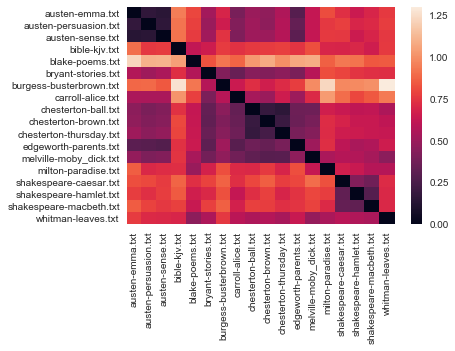

In [225]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference = 'KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Note that works by the same author have the lowest within-group KL divergences. 

To reveal more patterns, let's do a multidimensional scaling of the matrix.

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


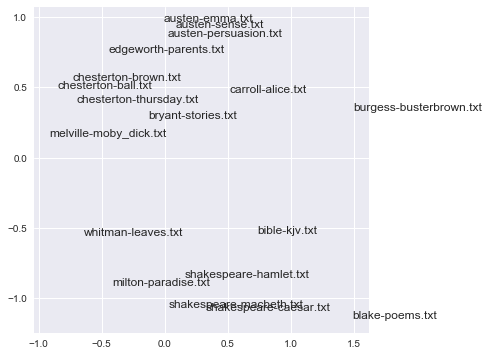

In [229]:
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids):
    ax.annotate(txt, (x[i],y[i]))

Do you see any patterns in the image shown above? Does it make sense?

We may just want to focus on the distrbution of stopwords or non-stopwords. Let's do the analysis again first for stopwords and then for non-stopwords.

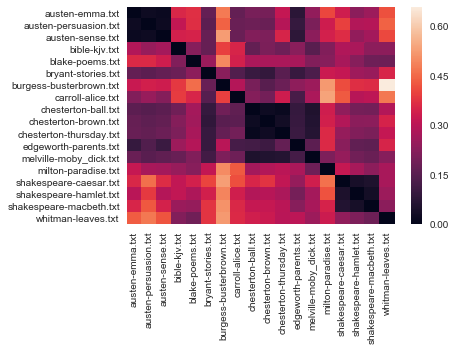

In [230]:
L = []
for p in corpora_s:
    l = []
    for q in corpora_s:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

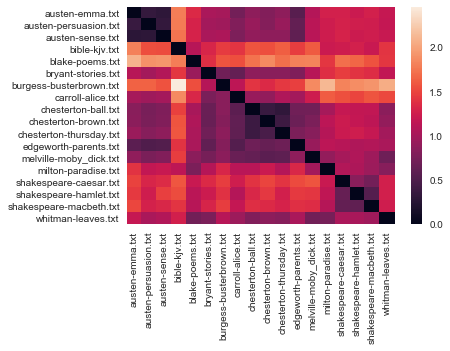

In [231]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KL'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

Now we compute the same for the assymmetric $\chi^2$ Divergence.

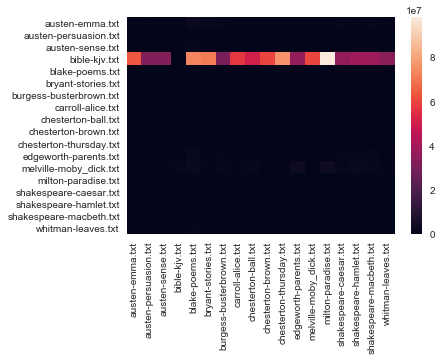

In [232]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Chi2'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

For the KS distance:

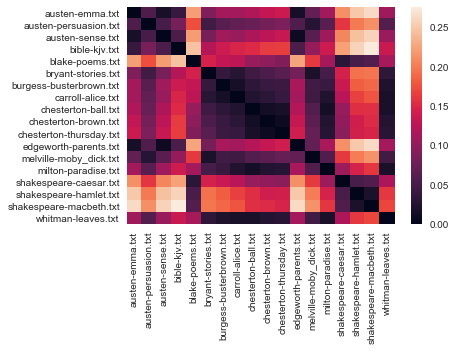

In [233]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

And finally for the Wasserstein or "earth mover's" Distance.

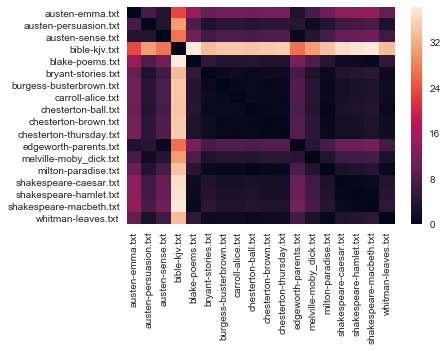

In [234]:
L = []
for p in corpora_nons:
    l = []
    for q in corpora_nons:
        l.append(Divergence(p,q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids, index = fileids)
ax = sns.heatmap(div)
plt.show()

You can see that the Bible is highly divergent and this makes reading the plot somewhat difficult. Let's fix this by taking the log of each cell, which will reduce the distance of the Bible from other texts as an outlier.

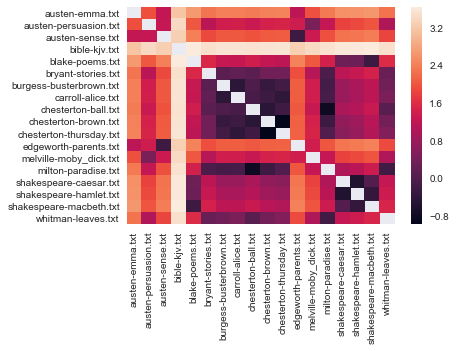

In [235]:
ax = sns.heatmap(div.apply(np.log).replace([np.inf, -np.inf], np.nan))
plt.show()

This is more legible, as it continues to show that the Bible is divergent, but other structure is also visible, such as the divergence of Austen's *Emma* and *Sense and Sensibility*, and Edgeworth's *The Parent's Assistant*. 

If we want to rerun this on a new data set of our own composition, we can be a bit more efficient with our coding. Let's use the Shakespeare texts from last week as example: 

In [236]:
shakespeare_df = lucem_illud.loadTextDirectory('../data/Shakespeare')

Now we stem and remove stopwords

In [237]:
shakespeare_df['tokenized_text'] = shakespeare_df['text'].apply(lambda x: nltk.word_tokenize(x))
shakespeare_df['normalized_tokens'] = shakespeare_df['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = porter))

Create the corpus file and generate the heatmap:

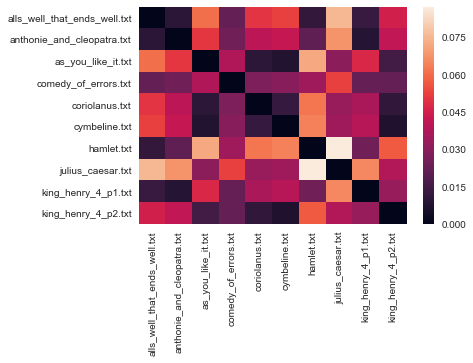

In [241]:
measure = 'KS' #"KL", "Chi2", "KS", "Wasserstein"
num_of_texts = 10 #The bigger this number the slower it will run, you can also try selecting your own plays
fileids_sp = list(shakespeare_df[:num_of_texts].index)
corpora_sp = list(shakespeare_df[:num_of_texts]['normalized_tokens'])
L = []
for p in corpora_sp:
    l = []
    for q in corpora_sp:
        l.append(Divergence(p,q, difference=measure))
    L.append(l)
M = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_sp, index = fileids_sp)
ax = sns.heatmap(div)
plt.show()

What are "The Passionate Pilgrim" and "The Phoenix and the Turtle"? Little known poems by Shakespeare that are unsurprisingly hard to classify, as they are so different from everything else he wrote.

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that calculate the KL and $\chi^2$ divergences, and the KS and Wasserstein distances between four separate corpora, plot these with heatmaps, and then array them in two dimensions with multidimensional scaling as above. What does this reveal about relations between the corpora? Which analysis (and divergence or distribution) distinguishes the authors or documents better? 

<span style="color:red">**Stretch**: Calculate the <a "href=https://en.wikipedia.org/wiki/Jensen–Shannon_divergence" target="_blank">Jensen-Shannon Divergence</a> between your four corpora. What is the relationship between the KL and JS divergences?</span> 

The four corpora I used for the divergence analysis are plot summaries of films directed by Woody Allen, Alfred Hitchcock, Stanley Kubrick, and Tim Burton.

In [242]:
# Read four corpora, stem and remove stopwords
StanleyKubrick = open('StanleyKubrick.txt','r')
StanleyKubrick = StanleyKubrick.read()
skTokens = nltk.word_tokenize(StanleyKubrick)
skText = nltk.Text(skTokens)

TimBurton = open('TimBurton.txt','r')
TimBurton = TimBurton.read()
tbTokens = nltk.word_tokenize(TimBurton)
tbText = nltk.Text(tbTokens)

waTokens_div = normlizeTokens(waTokens, stopwordLst = stop_words_nltk, stemmer = snowball)
ahTokens_div = normlizeTokens(ahTokens, stopwordLst = stop_words_nltk, stemmer = snowball)
skTokens_div = normlizeTokens(skTokens, stopwordLst = stop_words_nltk, stemmer = snowball)
tbTokens_div = normlizeTokens(tbTokens, stopwordLst = stop_words_nltk, stemmer = snowball)

In [247]:
corpora_div = [waTokens_div, ahTokens_div, skTokens_div, tbTokens_div]
fileids_div = ['Woody Allen', 'Alfred Hitchcock', 'Stanley Kubrick', 'Tim Burton']

KL divergences:
 [[0.         0.81318426 0.88184922 0.90681999]
 [0.71253043 0.         0.73766707 0.748822  ]
 [1.01627996 0.95982764 0.         1.00793913]
 [0.91502826 0.87416139 0.92803038 0.        ]]


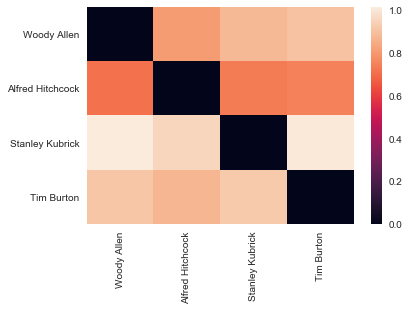

In [315]:
# KL divergences
L = []
for p in corpora_div:
    l = []
    for q in corpora_div:
        l.append(Divergence(p, q, difference = 'KL'))
    L.append(l)
M = np.array(L)
print('KL divergences:\n', M)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_div, index = fileids_div)
ax = sns.heatmap(div)
plt.show()

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


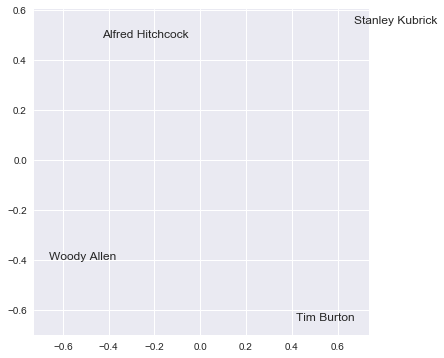

In [319]:
# multidimensional scaling of the matrix
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids_div):
    ax.annotate(txt, (x[i],y[i]))

We can observe that according to the KL divergence method, among all pairs of directors we anlyzed, the most similar pair is Alfred Hitchcock and Woody Allen, the least similar pair is Stanley Kubrick and Tim Burton. However, the difference of similarity between the six pairs of directors is not very obvious.

JS divergences:
 [[0.         0.22774574 0.22988858 0.23524075]
 [0.18220174 0.         0.20452805 0.19617469]
 [0.29221317 0.30273257 0.         0.29097159]
 [0.23567285 0.25009252 0.23190433 0.        ]]


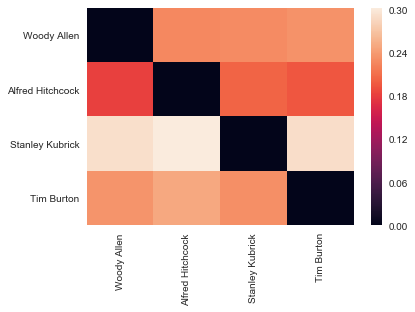

In [321]:
# JS divergences
L = []
for p in corpora_div:
    l = []
    for q in corpora_div:
        l.append(Divergence(p, q, difference = 'JS'))
    L.append(l)
M = np.array(L)
print('JS divergences:\n', M)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_div, index = fileids_div)
ax = sns.heatmap(div)
plt.show()

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


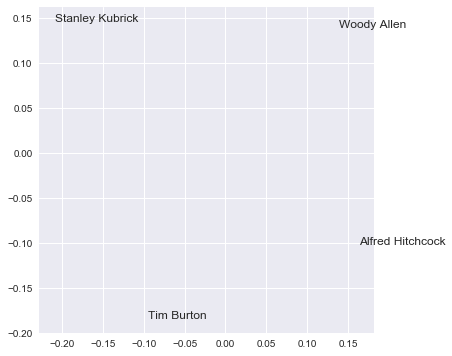

In [322]:
# multidimensional scaling of the matrix
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids_div):
    ax.annotate(txt, (x[i],y[i]))

assymmetric χ2 divergences:
 [[    0.         13262.33283887 12458.54093286 13631.37375328]
 [21811.70526807     0.         28860.23094078 21508.81620315]
 [ 9085.26833396 12668.1995328      0.          7851.67090931]
 [15430.07088188 13278.92649215 15724.31836037     0.        ]]


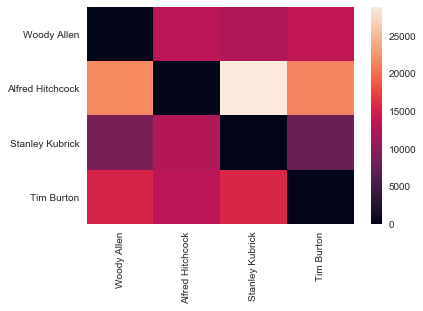

In [328]:
# assymmetric χ2 divergences
L = []
for p in corpora_div:
    l = []
    for q in corpora_div:
        l.append(Divergence(p, q, difference='Chi2'))
    L.append(l)
M = np.array(L)
print('assymmetric χ2 divergences:\n', M)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_div, index = fileids_div)
ax = sns.heatmap(div)
plt.show()

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


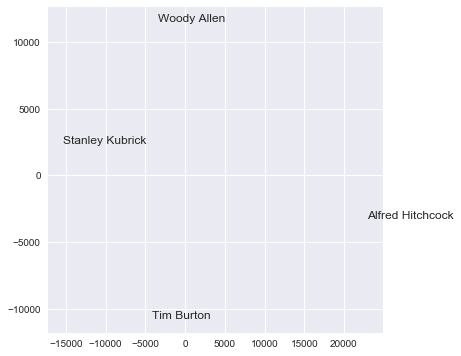

In [329]:
# multidimensional scaling of the matrix
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids_div):
    ax.annotate(txt, (x[i],y[i]))

The assymmetric χ2 divergences give somehow quite different results and distinguish the pairs of directors better. We can observe that among all pairs of directors we anlyzed, Alfred Hitchcock and Woody Allen are not that similar, Stanley Kubrick and Tim Burton are quite similar, actually, they are the most similar pair, and Alfred Hitchcock and Stanley Kubrick are the least similar pair.

KS distances:
 [[0.         0.06652599 0.05907327 0.01377435]
 [0.06652599 0.         0.11061669 0.06333532]
 [0.05907327 0.11061669 0.         0.04806179]
 [0.01377435 0.06333532 0.04806179 0.        ]]


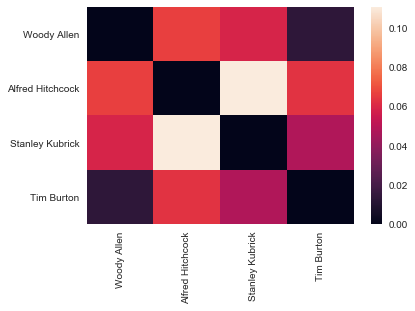

In [330]:
# KS distances
L = []
for p in corpora_div:
    l = []
    for q in corpora_div:
        l.append(Divergence(p, q, difference='KS'))
    L.append(l)
M = np.array(L)
print('KS distances:\n', M)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_div, index = fileids_div)
ax = sns.heatmap(div)
plt.show()

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


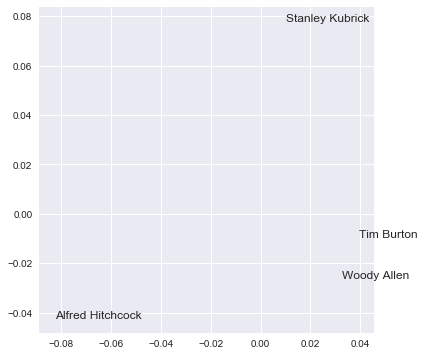

In [331]:
# multidimensional scaling of the matrix
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids_div):
    ax.annotate(txt, (x[i],y[i]))

Let's take a look at the pairs being highlighted in former analysis. According to KS distances, Alfred Hitchcock and Woody Allen are still not that similar, Stanley Kubrick and Tim Burton are pretty similar but the most similar pair becomes Tim Burton and Woody Allen, Alfred Hitchcock and Stanley Kubrick is still the least similar pair.

Wasserstein distances:
 [[0.         0.76126142 0.81307618 0.26410325]
 [0.76126142 0.         1.57409499 1.00009382]
 [0.81307618 1.57409499 0.         0.57400117]
 [0.26410325 1.00009382 0.57400117 0.        ]]


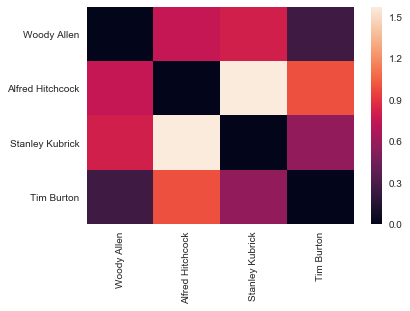

In [332]:
# Wasserstein distances
L = []
for p in corpora_div:
    l = []
    for q in corpora_div:
        l.append(Divergence(p, q, difference='Wasserstein'))
    L.append(l)
M = np.array(L)
print('Wasserstein distances:\n', M)
fig = plt.figure()
div = pandas.DataFrame(M, columns = fileids_div, index = fileids_div)
ax = sns.heatmap(div)
plt.show()

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/sklearn/manifold/mds.py:411: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


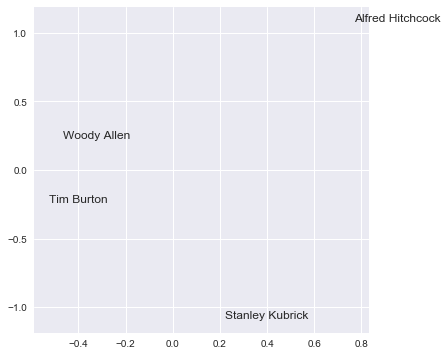

In [333]:
# multidimensional scaling of the matrix
mds = sklearn.manifold.MDS()
pos = mds.fit(M).embedding_
x = pos[:,0]
y = pos[:,1]
fig, ax = plt.subplots(figsize = (6,6))
plt.plot(x, y, ' ')
for i, txt in enumerate(fileids_div):
    ax.annotate(txt, (x[i],y[i]))

We can observe that Wasserstein distances have almost given the same results with KS distances.

According to the heatmaps and multidimensional scaling of the matrices above, we can conclude that the chi-square divergence has distinguished the corpora best.